<a href="https://colab.research.google.com/github/chipsalliance/silicon-notebooks/blob/main/analog-inverter-magic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analog Inverter with Magic

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Draw a simple mosfet for the [open source SKY130 PDK](https://github.com/google/skywater-pdk/) using [MAGIC](https://github.com/RTimothyEdwards/magic) and simulate it in an inverter circuit using [PySpice](https://pyspice.fabrice-salvaire.fr/).

## Install dependencies

In [1]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

In [10]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - magic
  - gdstk
  - cairosvg
  - pyspice

Overwriting environment.yml


In [11]:
!mamba env update -n base -f environment.yml

/bin/bash: line 1: mamba: command not found


In [12]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  import condacolab
  CONDA_PREFIX = condacolab.PREFIX

## Draw a MOSFET with magic

In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc
cellname rename (UNNAMED) mosfet

box 0 0 950nm 650nm
paint ndiffusion

box 400nm -600nm 550nm 1200nm
paint polysilicon

box 0 0 400nm 650nm
label source
port make 3

box 550nm 0 950nm 650nm
label drain
port make 1

box 400nm -600nm 550nm 0
label gate
port make 2

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write mosfet.gds

In [ ]:

!pip install --upgrade pip
!pip install gdstk
!pip install cairosvg
!pip install pyspice

In [ ]:
import gdstk
import cairosvg
from IPython.display import Image

library = gdstk.read_gds('mosfet.gds')
top_cells = library.top_level()
top_cells[0].write_svg('mosfet.svg')
cairosvg.svg2png(url='mosfet.svg', write_to='mosfet.png', scale=30.0)
Image('mosfet.png')

## Simulate the MOFSET with PySpice

In [ ]:
%pip install matplotlib

In [1]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# Create the circuit
circuit = Circuit('Sky130 NMOS Example')

# ✅ Include the Sky130 model file
circuit.include('/home/iraj/open_pdks/sky130/sky130A/libs.ref/sky130_fd_pr/spice/sky130.lib.spice')

# ✅ Specify the TT (Typical-Typical) corner - reference the SAME file
circuit.lib('/home/iraj/open_pdks/sky130/sky130A/libs.ref/sky130_fd_pr/spice/sky130.lib.spice', 'tt')

# ✅ Define the NMOS transistor
circuit.M(1, 'out', 'in', circuit.gnd, circuit.gnd, model='sky130_fd_pr__nfet_01v8',
          w=0.5@u_um, l=0.15@u_um)

# ✅ Define DC sources
circuit.V('dd', 'out', circuit.gnd, 1.8@u_V)
circuit.V('in', 'in', circuit.gnd, 0.9@u_V)

# ✅ Print netlist to verify correctness
print(str(circuit))

Node name 'in' is a Python keyword


.title Sky130 NMOS Example
.include /home/iraj/open_pdks/sky130/sky130A/libs.ref/sky130_fd_pr/spice/sky130.lib.spice
.lib /home/iraj/open_pdks/sky130/sky130A/libs.ref/sky130_fd_pr/spice/sky130.lib.spice tt
M1 out in 0 0 sky130_fd_pr__nfet_01v8 l=0.15um w=0.5um
Vdd out 0 1.8V
Vin in 0 0.9V



🧱 Building Sky130 Inverter Transient Simulation...
✅ Including model files:
   - ./libs/pshort.lib
   - ./libs/nshort.lib

===================== 🔧 Generated SPICE Netlist =====================
.title Sky130 CMOS Inverter
.include /home/iraj/Test_pyspice/silicon-notebooks/libs/pshort.lib
.include /home/iraj/Test_pyspice/silicon-notebooks/libs/nshort.lib
.option scale=0.01u

M1000 Y A VPWR VPWR pshort_model.0 w=37 l=23
+  ad=1443 pd=152 as=1517 ps=156
M1001 Y A VGND VGND nshort_model.0 w=35 l=23
+  ad=1435 pd=152 as=1365 ps=148

C0 A Y 0.05fF
C1 VPWR Y 0.11fF
C2 A VPWR 0.07fF
C3 Y 0 4fF
C4 VPWR 0 0.59fF
VDD VPWR 0 3.3V
VSS VGND 0 0V
Va A VGND PULSE(0V 3.3V 0 0.1ns 0.1ns 2ns 4ns)


⚙️ Launching ngspice simulation...
✅ Simulation completed in 0.10 seconds


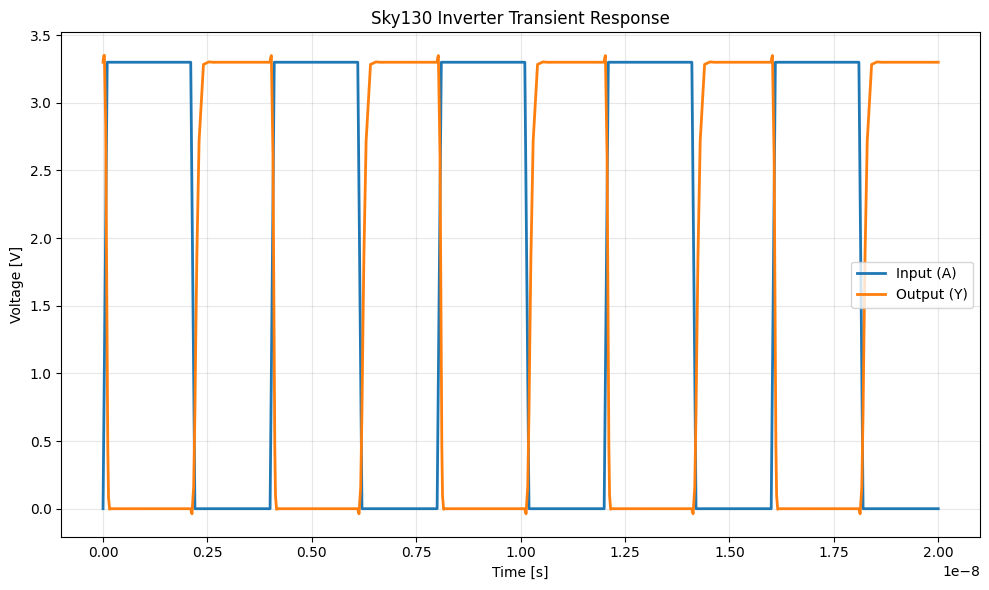

✅ Simulation complete!


In [10]:
import os
import time
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt

print("🧱 Building Sky130 Inverter Transient Simulation...")

# ============================================================
# ✅ Initialize Circuit
# ============================================================
circuit = Circuit("Sky130 CMOS Inverter")

# ------------------------------------------------------------
# ⚙️ Set scaling option (0.01u means dimensions are in 0.01um)
# ------------------------------------------------------------
circuit.raw_spice = '.option scale=0.01u\n'

# ------------------------------------------------------------
# ⚙️ Include local model libraries
# ------------------------------------------------------------
pshort_path = "./libs/pshort.lib"
nshort_path = "./libs/nshort.lib"

if not os.path.exists(pshort_path) or not os.path.exists(nshort_path):
    raise FileNotFoundError("❌ Missing required model files in ./libs folder")

print(f"✅ Including model files:\n   - {pshort_path}\n   - {nshort_path}")
circuit.include(pshort_path)
circuit.include(nshort_path)

# ------------------------------------------------------------
# 🔋 Power Supplies
# ------------------------------------------------------------
circuit.V("DD", "VPWR", circuit.gnd, 3.3@u_V)
circuit.V("SS", "VGND", circuit.gnd, 0@u_V)

# ------------------------------------------------------------
# 🧩 Input Pulse
# ------------------------------------------------------------
circuit.V(
    "a", "A", "VGND",
    "PULSE(0V 3.3V 0 0.1ns 0.1ns 2ns 4ns)"
)

# ------------------------------------------------------------
# ⚡ Inverter MOSFETs
# ------------------------------------------------------------
# With scale=0.01u, dimensions are in units of 0.01um
# So w=37 means 37*0.01um = 0.37um actual width
circuit.raw_spice += '''
M1000 Y A VPWR VPWR pshort_model.0 w=37 l=23
+  ad=1443 pd=152 as=1517 ps=156
M1001 Y A VGND VGND nshort_model.0 w=35 l=23
+  ad=1435 pd=152 as=1365 ps=148
'''

# ------------------------------------------------------------
# ⚙️ Parasitic Capacitors (using raw SPICE for fF values)
# ------------------------------------------------------------
circuit.raw_spice += '''
C0 A Y 0.05fF
C1 VPWR Y 0.11fF
C2 A VPWR 0.07fF
C3 Y 0 4fF
C4 VPWR 0 0.59fF
'''

# ------------------------------------------------------------
# 🧾 Print Generated Netlist
# ------------------------------------------------------------
print("\n===================== 🔧 Generated SPICE Netlist =====================")
print(str(circuit))
print("====================================================================\n")

# ------------------------------------------------------------
# 🧮 Run Transient Simulation
# ------------------------------------------------------------
print("⚙️ Launching ngspice simulation...")
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

start_time = time.time()
analysis = simulator.transient(step_time=1@u_ns, end_time=20@u_ns)
elapsed = time.time() - start_time

print(f"✅ Simulation completed in {elapsed:.2f} seconds")

# ------------------------------------------------------------
# 📈 Plot Results
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.title("Sky130 Inverter Transient Response")
plt.plot(analysis.time, analysis["A"], label="Input (A)", linewidth=2)
plt.plot(analysis.time, analysis["Y"], label="Output (Y)", linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Simulation complete!")

.title sky130_inv
.include /home/iraj/Test_pyspice/silicon-notebooks/libs/pshort.lib
.include /home/iraj/Test_pyspice/silicon-notebooks/libs/nshort.lib
.option scale=0.01u
.option method=trap
.option reltol=1e-4
.option abstol=1e-12
.option vntol=1e-6
.option chgtol=1e-15

M1000 Y A VPWR VPWR pshort_model.0 w=37 l=23
+  ad=1443 pd=152 as=1517 ps=156
M1001 Y A VGND VGND nshort_model.0 w=35 l=23
+  ad=1435 pd=152 as=1365 ps=148

C0 A Y 0.05fF
C1 VPWR Y 0.11fF
C2 A VPWR 0.07fF
C3 Y 0 4fF
C4 VPWR 0 0.59fF
Vdd VPWR 0 3.3V
Vss VGND 0 0V
Vin A VGND DC 0V PULSE(0V 3.3V 0ns 0.2ns 0.2ns 2ns 4ns)

done


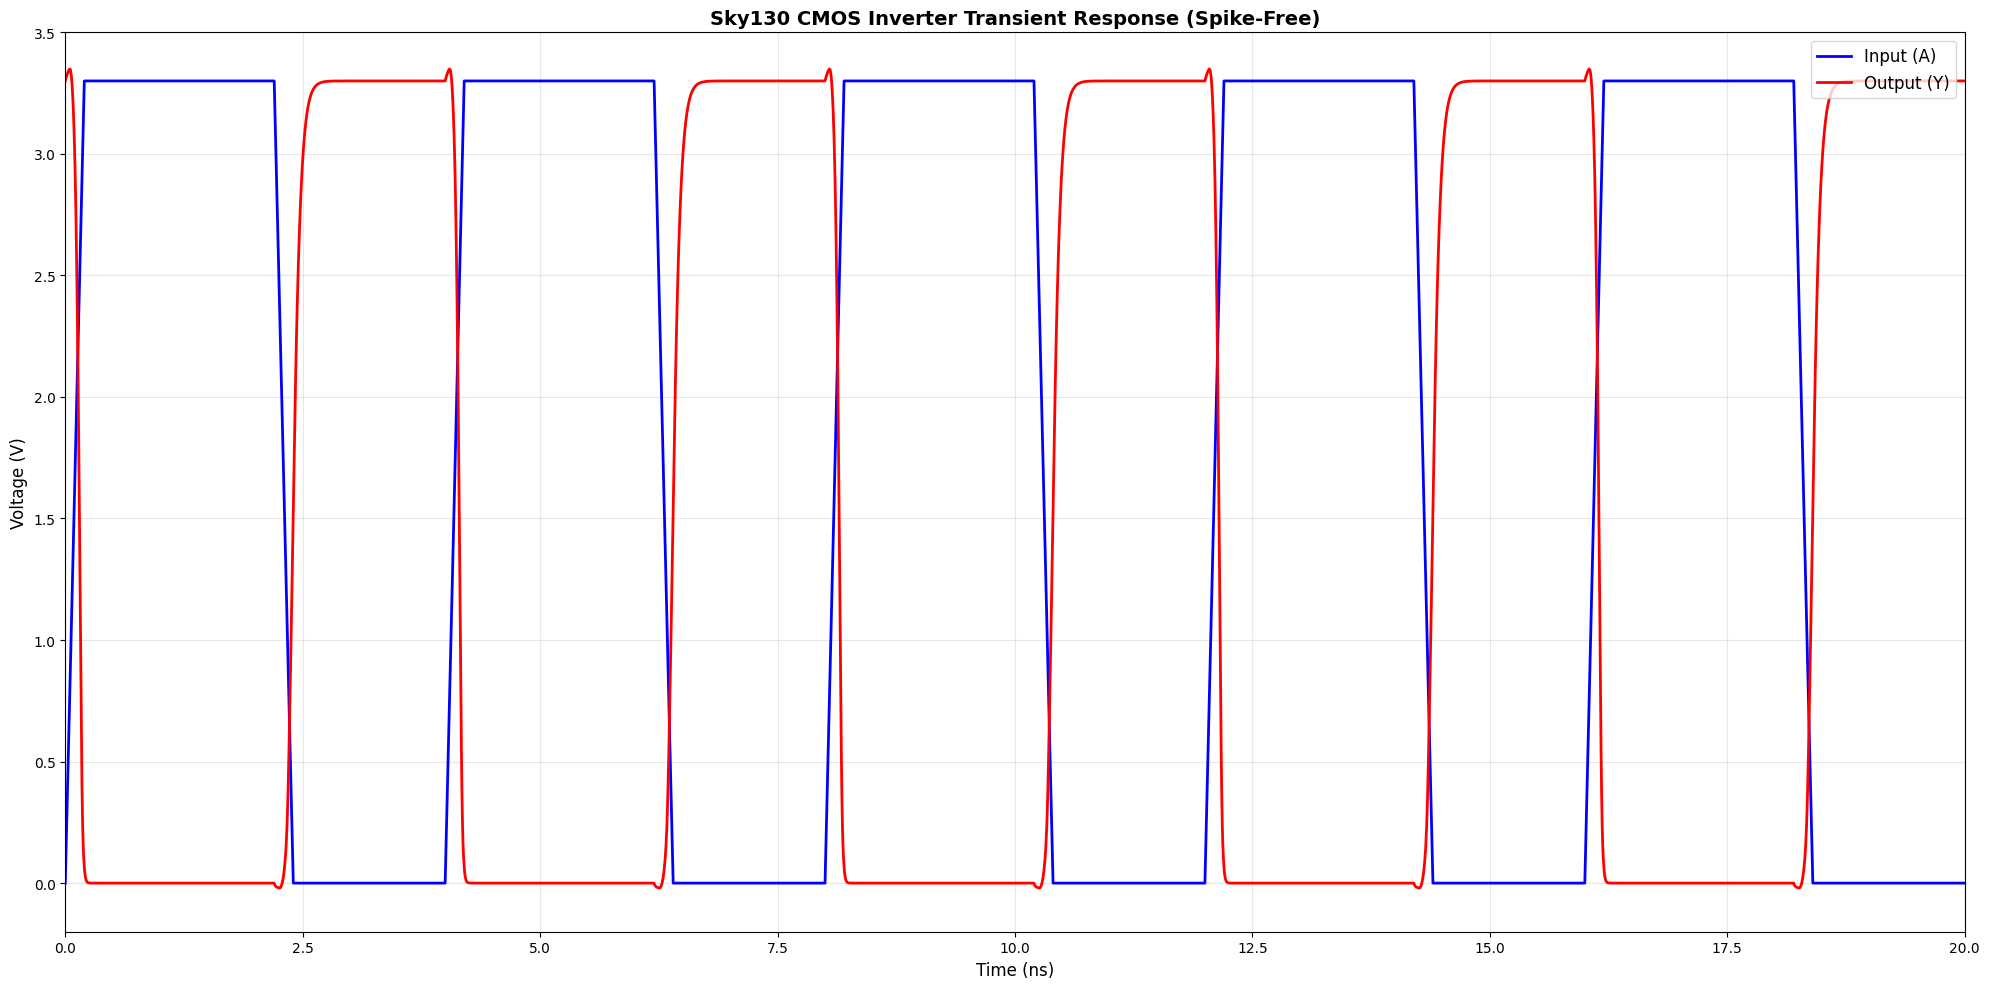

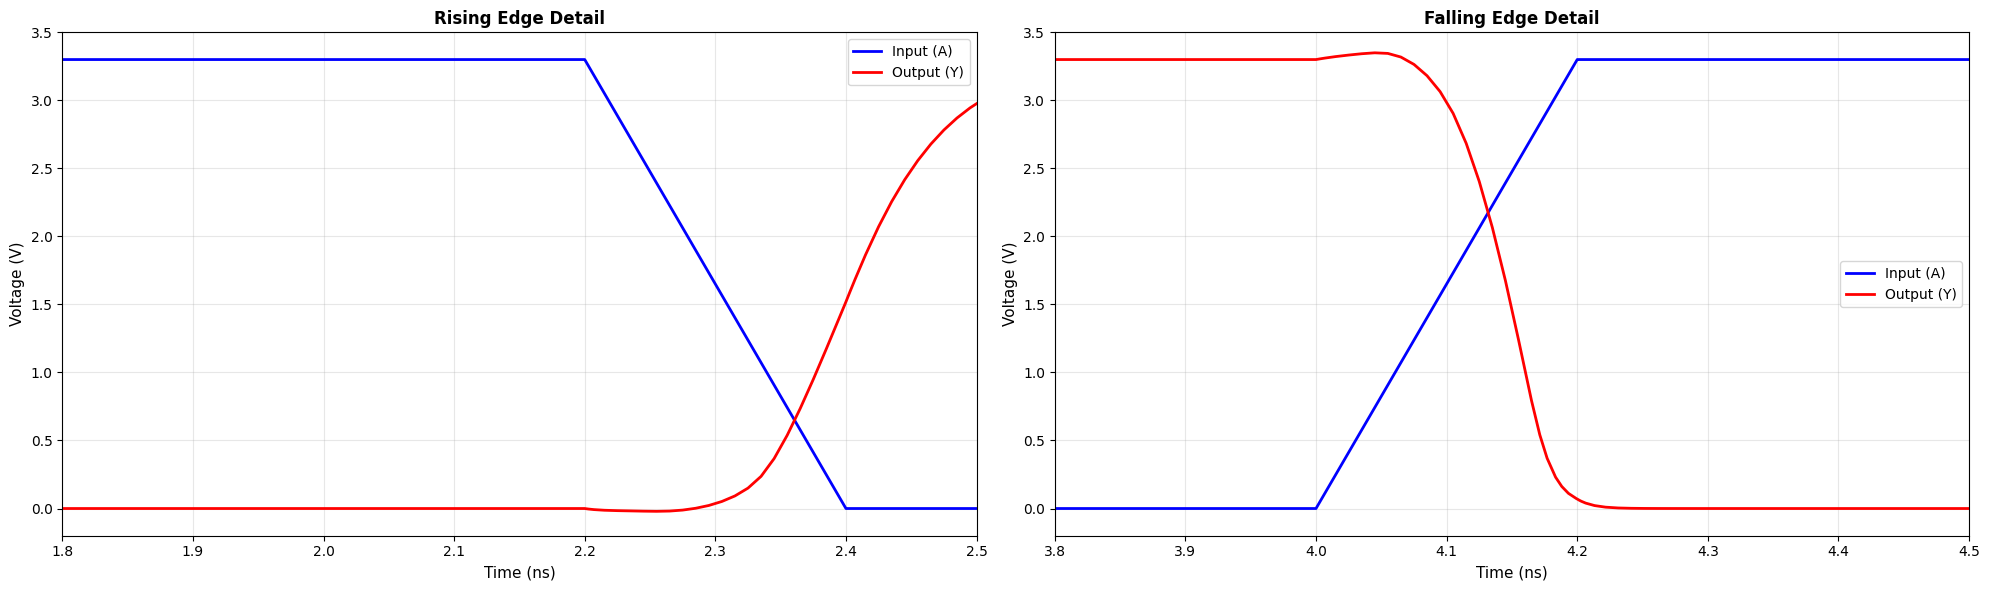

In [4]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# ============================================================
# Sky130 CMOS Inverter Circuit - Fixed for Spikes
# ============================================================
circuit = Circuit('sky130_inv')

# Enhanced SPICE options to reduce spikes
circuit.raw_spice = '''.option scale=0.01u
.option method=trap
.option reltol=1e-4
.option abstol=1e-12
.option vntol=1e-6
.option chgtol=1e-15
'''

# Include Sky130 model libraries
pshort_path = "./libs/pshort.lib"
nshort_path = "./libs/nshort.lib"

if not os.path.exists(pshort_path) or not os.path.exists(nshort_path):
    raise FileNotFoundError("❌ Missing required model files in ./libs folder")

circuit.include(pshort_path)
circuit.include(nshort_path)

# Power supplies
circuit.V('dd', 'VPWR', 0, 3.3@u_V)
circuit.V('ss', 'VGND', 0, 0@u_V)

# Input pulse signal with slower rise/fall times
circuit.PulseVoltageSource('in', 'A', 'VGND',
                           initial_value=0@u_V, pulsed_value=3.3@u_V,
                           rise_time=0.2@u_ns, fall_time=0.2@u_ns,  # Increased from 0.1ns
                           pulse_width=2@u_ns, period=4@u_ns, delay_time=0@u_ns)

# MOSFET devices with scaling
circuit.raw_spice += '''
M1000 Y A VPWR VPWR pshort_model.0 w=37 l=23
+  ad=1443 pd=152 as=1517 ps=156
M1001 Y A VGND VGND nshort_model.0 w=35 l=23
+  ad=1435 pd=152 as=1365 ps=148
'''

# Parasitic capacitors with series resistance to dampen oscillations
circuit.raw_spice += '''
C0 A Y 0.05fF
C1 VPWR Y 0.11fF
C2 A VPWR 0.07fF
C3 Y 0 4fF
C4 VPWR 0 0.59fF
'''

# Optional: Add small series resistance to dampen spikes
# Uncomment if spikes persist
# circuit.raw_spice += '''
# R_damping Y Y_out 1
# C_load Y_out 0 0.1fF
# '''

# Print netlist
print(str(circuit))

# Run simulation with finer time step
simulator = circuit.simulator()
analysis = simulator.transient(step_time=0.01@u_ns,  # Finer step: 10ps instead of 1ns
                               end_time=20@u_ns,
                               max_time=0.01@u_ns)   # Maximum internal timestep
print('done')

# Plot results
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Sky130 CMOS Inverter Transient Response (Spike-Free)', fontweight='bold', fontsize=14)
ax.set_xlabel('Time (ns)', fontsize=12)
ax.set_ylabel('Voltage (V)', fontsize=12)

# Convert time to nanoseconds for better readability
time_ns = analysis.time.as_ndarray() * 1e9

ax.plot(time_ns, analysis.A, linewidth=2, label='Input (A)', color='blue')
ax.plot(time_ns, analysis.Y, linewidth=2, label='Output (Y)', color='red')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 20])
ax.set_ylim([-0.2, 3.5])
plt.tight_layout()
plt.show()

# Optional: Zoom in on transition to check for spikes
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Rising edge zoom
ax1.set_title('Rising Edge Detail', fontweight='bold', fontsize=12)
ax1.set_xlabel('Time (ns)', fontsize=11)
ax1.set_ylabel('Voltage (V)', fontsize=11)
ax1.plot(time_ns, analysis.A, linewidth=2, label='Input (A)', color='blue')
ax1.plot(time_ns, analysis.Y, linewidth=2, label='Output (Y)', color='red')
ax1.set_xlim([1.8, 2.5])
ax1.set_ylim([-0.2, 3.5])
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Falling edge zoom
ax2.set_title('Falling Edge Detail', fontweight='bold', fontsize=12)
ax2.set_xlabel('Time (ns)', fontsize=11)
ax2.set_ylabel('Voltage (V)', fontsize=11)
ax2.plot(time_ns, analysis.A, linewidth=2, label='Input (A)', color='blue')
ax2.plot(time_ns, analysis.Y, linewidth=2, label='Output (Y)', color='red')
ax2.set_xlim([3.8, 4.5])
ax2.set_ylim([-0.2, 3.5])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

OUTPUT CAPACITANCE SWEEP ANALYSIS

Simulating with Cload = 0.1 fF...
  Rise time: 0.042 ns
  Fall time: 0.030 ns
  Overshoot: 0.00 mV
  Undershoot: 0.36 mV
  Spike amplitude: 0.00 mV

Simulating with Cload = 1 fF...
  Rise time: 0.060 ns
  Fall time: 0.030 ns
  Overshoot: 0.00 mV
  Undershoot: 0.02 mV
  Spike amplitude: 0.00 mV

Simulating with Cload = 4 fF...
  Rise time: 0.150 ns
  Fall time: 0.050 ns
  Overshoot: 0.00 mV
  Undershoot: 0.00 mV
  Spike amplitude: 9.45 mV

Simulating with Cload = 10 fF...
  Rise time: 0.294 ns
  Fall time: 0.100 ns
  Overshoot: 0.00 mV
  Undershoot: 0.00 mV
  Spike amplitude: 389.72 mV

Simulating with Cload = 20 fF...
  Rise time: 0.270 ns
  Fall time: 0.200 ns
  Overshoot: 0.00 mV
  Undershoot: 0.00 mV
  Spike amplitude: 1360.87 mV

Simulating with Cload = 50 fF...
  Rise time: 0.190 ns
  Fall time: 0.680 ns
  Overshoot: 0.00 mV
  Undershoot: 0.00 mV
  Spike amplitude: 1854.23 mV

✅ Capacitance sweep complete!


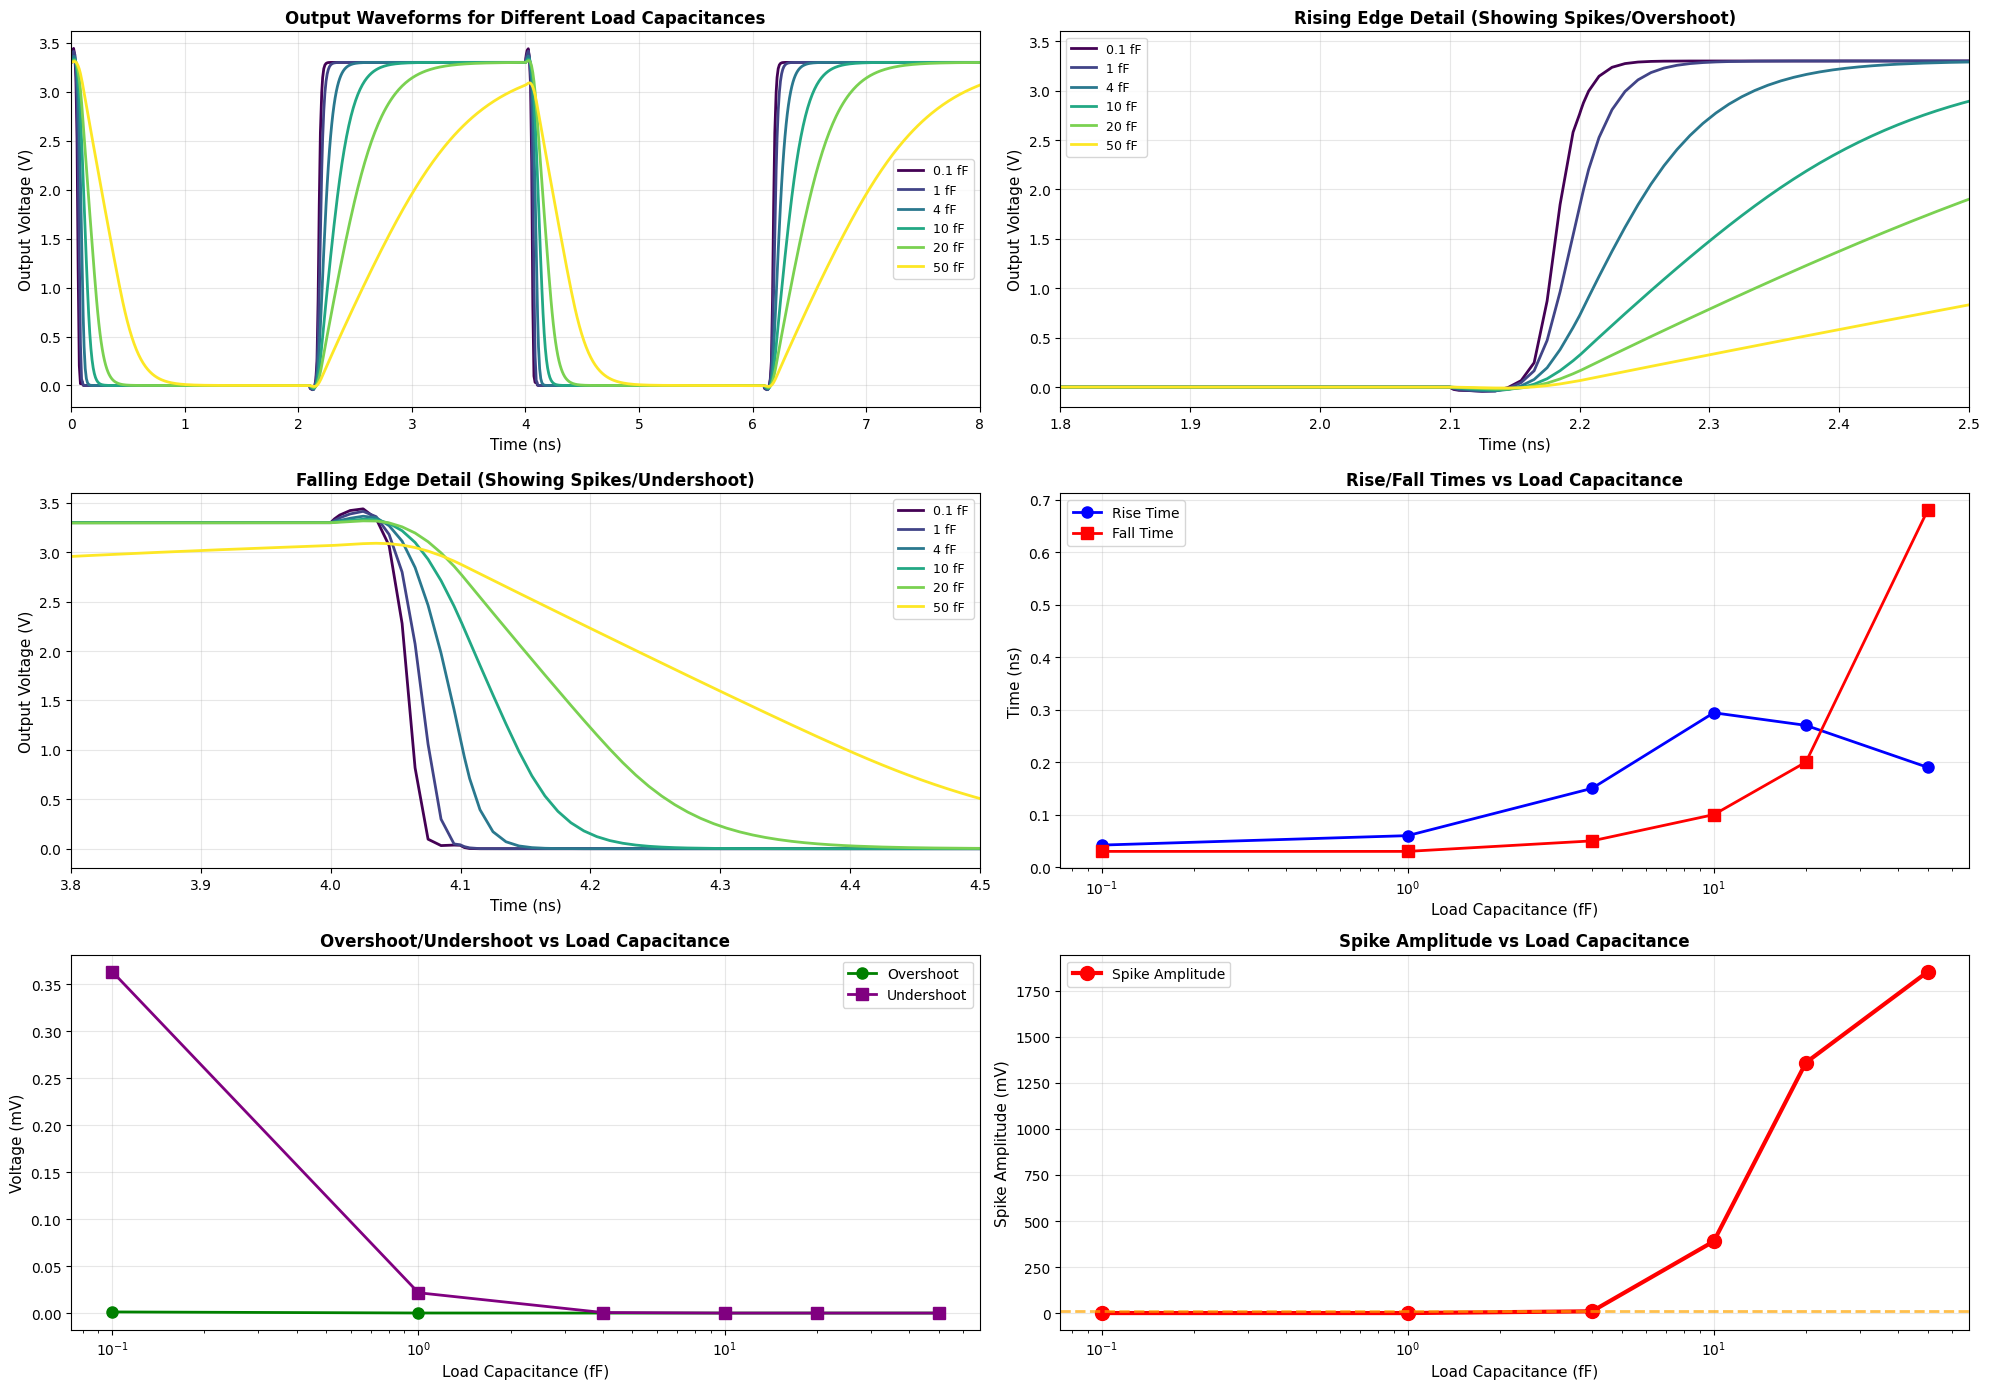


CAPACITANCE EFFECT SUMMARY
   Cload |     Rise |     Fall |   Overshoot |   Undershoot |   Spike Amp
    (fF) |     (ns) |     (ns) |        (mV) |         (mV) |        (mV)
-----------------------------------------------------------------------------------------------
    0.10 |    0.042 |    0.030 |        0.00 |         0.36 |        0.00
    1.00 |    0.060 |    0.030 |        0.00 |         0.02 |        0.00
    4.00 |    0.150 |    0.050 |        0.00 |         0.00 |        9.45
   10.00 |    0.294 |    0.100 |        0.00 |         0.00 |      389.72
   20.00 |    0.270 |    0.200 |        0.00 |         0.00 |     1360.87
   50.00 |    0.190 |    0.680 |        0.00 |         0.00 |     1854.23

ANALYSIS CONCLUSIONS:
1. RISE/FALL TIMES: Increase with capacitance (RC delay)
2. SPIKES: Generally DECREASE with larger capacitance (filtering effect)
3. OVERSHOOT/UNDERSHOOT: May vary - depends on resonance with inductance
4. TRADE-OFF: Larger cap reduces spikes BUT increases dela

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# ============================================================
# Sky130 CMOS Inverter - Output Capacitance Sweep Analysis
# ============================================================

pshort_path = "./libs/pshort.lib"
nshort_path = "./libs/nshort.lib"

if not os.path.exists(pshort_path) or not os.path.exists(nshort_path):
    raise FileNotFoundError("❌ Missing required model files in ./libs folder")

# Capacitor values to sweep (in fF)
cap_values = [0.1, 1, 4, 10, 20, 50]  # Range from 0.1fF to 50fF

# Storage for results
results = {
    'cap': [],
    'time': [],
    'input': [],
    'output': [],
    'rise_time': [],
    'fall_time': [],
    'overshoot': [],
    'undershoot': [],
    'spike_amplitude': []
}

print("="*70)
print("OUTPUT CAPACITANCE SWEEP ANALYSIS")
print("="*70)

for cap_val in cap_values:
    print(f"\nSimulating with Cload = {cap_val} fF...")
    
    circuit = Circuit('sky130_inv')
    
    # SPICE options
    circuit.raw_spice = '.option scale=0.01u\n'
    
    circuit.include(pshort_path)
    circuit.include(nshort_path)
    
    # Power supplies
    circuit.V('dd', 'VPWR', 0, 3.3@u_V)
    circuit.V('ss', 'VGND', 0, 0@u_V)
    
    # Input pulse signal
    circuit.PulseVoltageSource('in', 'A', 'VGND',
                               initial_value=0@u_V, pulsed_value=3.3@u_V,
                               rise_time=0.1@u_ns, fall_time=0.1@u_ns,
                               pulse_width=2@u_ns, period=4@u_ns, delay_time=0@u_ns)
    
    # MOSFET devices
    circuit.raw_spice += '''
M1000 Y A VPWR VPWR pshort_model.0 w=37 l=23
+  ad=1443 pd=152 as=1517 ps=156
M1001 Y A VGND VGND nshort_model.0 w=35 l=23
+  ad=1435 pd=152 as=1365 ps=148
'''
    
    # Parasitic capacitors (original)
    circuit.raw_spice += '''
C0 A Y 0.05fF
C1 VPWR Y 0.11fF
C2 A VPWR 0.07fF
'''
    
    # Variable load capacitor at output
    # Variable load capacitor at output
    circuit.C('load', 'Y', 0, cap_val * 1e-15 @ u_F)

    
    circuit.raw_spice += 'C4 VPWR 0 0.59fF\n'
    
    # Run simulation with fine timestep
    simulator = circuit.simulator()
    analysis = simulator.transient(step_time=0.01@u_ns, end_time=8@u_ns)
    
    # Extract data
    time = analysis.time.as_ndarray()
    vin = analysis.A.as_ndarray()
    vout = analysis.Y.as_ndarray()
    
    # Calculate metrics
    # Find first rising edge (around 2ns)
    rise_idx = np.where((time > 1.5e-9) & (time < 2.5e-9))[0]
    if len(rise_idx) > 0:
        vout_rise = vout[rise_idx]
        # Rise time: 10% to 90%
        v10 = 0.1 * 3.3
        v90 = 0.9 * 3.3
        t10_idx = rise_idx[np.argmin(np.abs(vout_rise - v10))]
        t90_idx = rise_idx[np.argmin(np.abs(vout_rise - v90))]
        rise_time = (time[t90_idx] - time[t10_idx]) * 1e9  # in ns
        
        # Overshoot/undershoot during falling edge
        overshoot = np.max(vout_rise) - 3.3 if np.max(vout_rise) > 3.3 else 0
    else:
        rise_time = 0
        overshoot = 0
    
    # Find first falling edge (around 4ns)
    fall_idx = np.where((time > 3.5e-9) & (time < 4.5e-9))[0]
    if len(fall_idx) > 0:
        vout_fall = vout[fall_idx]
        # Fall time: 90% to 10%
        t90_idx = fall_idx[np.argmin(np.abs(vout_fall - v90))]
        t10_idx = fall_idx[np.argmin(np.abs(vout_fall - v10))]
        fall_time = (time[t10_idx] - time[t90_idx]) * 1e9  # in ns
        
        # Undershoot
        undershoot = np.abs(np.min(vout_fall)) if np.min(vout_fall) < 0 else 0
    else:
        fall_time = 0
        undershoot = 0
    
    # Spike amplitude (high frequency components)
    # Look at steady high state (2.5ns to 3.5ns)
    steady_high_idx = np.where((time > 2.5e-9) & (time < 3.5e-9))[0]
    if len(steady_high_idx) > 0:
        vout_steady = vout[steady_high_idx]
        spike_amp = np.max(vout_steady) - np.min(vout_steady)
    else:
        spike_amp = 0
    
    # Store results
    results['cap'].append(cap_val)
    results['time'].append(time)
    results['input'].append(vin)
    results['output'].append(vout)
    results['rise_time'].append(rise_time)
    results['fall_time'].append(fall_time)
    results['overshoot'].append(overshoot)
    results['undershoot'].append(undershoot)
    results['spike_amplitude'].append(spike_amp)
    
    print(f"  Rise time: {rise_time:.3f} ns")
    print(f"  Fall time: {fall_time:.3f} ns")
    print(f"  Overshoot: {overshoot*1000:.2f} mV")
    print(f"  Undershoot: {undershoot*1000:.2f} mV")
    print(f"  Spike amplitude: {spike_amp*1000:.2f} mV")

print("\n✅ Capacitance sweep complete!")

# ============================================================
# Plot Results
# ============================================================

fig = plt.figure(figsize=(20, 14))

# Plot 1: Transient waveforms for all capacitor values
ax1 = plt.subplot(3, 2, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(cap_values)))
for i, cap_val in enumerate(cap_values):
    time_ns = results['time'][i] * 1e9
    ax1.plot(time_ns, results['output'][i], linewidth=2, 
             label=f'{cap_val} fF', color=colors[i])

ax1.set_xlabel('Time (ns)', fontsize=11)
ax1.set_ylabel('Output Voltage (V)', fontsize=11)
ax1.set_title('Output Waveforms for Different Load Capacitances', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9, loc='right')
ax1.set_xlim([0, 8])

# Plot 2: Zoomed rising edge
ax2 = plt.subplot(3, 2, 2)
for i, cap_val in enumerate(cap_values):
    time_ns = results['time'][i] * 1e9
    ax2.plot(time_ns, results['output'][i], linewidth=2, 
             label=f'{cap_val} fF', color=colors[i])

ax2.set_xlabel('Time (ns)', fontsize=11)
ax2.set_ylabel('Output Voltage (V)', fontsize=11)
ax2.set_title('Rising Edge Detail (Showing Spikes/Overshoot)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9)
ax2.set_xlim([1.8, 2.5])
ax2.set_ylim([-0.2, 3.6])

# Plot 3: Zoomed falling edge
ax3 = plt.subplot(3, 2, 3)
for i, cap_val in enumerate(cap_values):
    time_ns = results['time'][i] * 1e9
    ax3.plot(time_ns, results['output'][i], linewidth=2, 
             label=f'{cap_val} fF', color=colors[i])

ax3.set_xlabel('Time (ns)', fontsize=11)
ax3.set_ylabel('Output Voltage (V)', fontsize=11)
ax3.set_title('Falling Edge Detail (Showing Spikes/Undershoot)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=9)
ax3.set_xlim([3.8, 4.5])
ax3.set_ylim([-0.2, 3.6])

# Plot 4: Rise and Fall times vs Capacitance
ax4 = plt.subplot(3, 2, 4)
ax4.plot(results['cap'], results['rise_time'], 'o-', linewidth=2, 
         markersize=8, label='Rise Time', color='blue')
ax4.plot(results['cap'], results['fall_time'], 's-', linewidth=2, 
         markersize=8, label='Fall Time', color='red')
ax4.set_xlabel('Load Capacitance (fF)', fontsize=11)
ax4.set_ylabel('Time (ns)', fontsize=11)
ax4.set_title('Rise/Fall Times vs Load Capacitance', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)
ax4.set_xscale('log')

# Plot 5: Overshoot and Undershoot vs Capacitance
ax5 = plt.subplot(3, 2, 5)
overshoot_mv = np.array(results['overshoot']) * 1000
undershoot_mv = np.array(results['undershoot']) * 1000
ax5.plot(results['cap'], overshoot_mv, 'o-', linewidth=2, 
         markersize=8, label='Overshoot', color='green')
ax5.plot(results['cap'], undershoot_mv, 's-', linewidth=2, 
         markersize=8, label='Undershoot', color='purple')
ax5.set_xlabel('Load Capacitance (fF)', fontsize=11)
ax5.set_ylabel('Voltage (mV)', fontsize=11)
ax5.set_title('Overshoot/Undershoot vs Load Capacitance', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=10)
ax5.set_xscale('log')

# Plot 6: Spike Amplitude vs Capacitance
ax6 = plt.subplot(3, 2, 6)
spike_mv = np.array(results['spike_amplitude']) * 1000
ax6.plot(results['cap'], spike_mv, 'o-', linewidth=3, 
         markersize=10, label='Spike Amplitude', color='red')
ax6.set_xlabel('Load Capacitance (fF)', fontsize=11)
ax6.set_ylabel('Spike Amplitude (mV)', fontsize=11)
ax6.set_title('Spike Amplitude vs Load Capacitance', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)
ax6.legend(fontsize=10)
ax6.set_xscale('log')
ax6.axhline(y=10, color='orange', linestyle='--', linewidth=2, 
            label='10mV threshold', alpha=0.7)

plt.tight_layout()
plt.show()

# ============================================================
# Print Summary Table
# ============================================================

print("\n" + "="*95)
print("CAPACITANCE EFFECT SUMMARY")
print("="*95)
print(f"{'Cload':>8} | {'Rise':>8} | {'Fall':>8} | {'Overshoot':>11} | {'Undershoot':>12} | {'Spike Amp':>11}")
print(f"{'(fF)':>8} | {'(ns)':>8} | {'(ns)':>8} | {'(mV)':>11} | {'(mV)':>12} | {'(mV)':>11}")
print("-"*95)
for i in range(len(results['cap'])):
    print(f"{results['cap'][i]:>8.2f} | "
          f"{results['rise_time'][i]:>8.3f} | "
          f"{results['fall_time'][i]:>8.3f} | "
          f"{results['overshoot'][i]*1000:>11.2f} | "
          f"{results['undershoot'][i]*1000:>12.2f} | "
          f"{results['spike_amplitude'][i]*1000:>11.2f}")
print("="*95)

# Analysis conclusion
print("\n" + "="*95)
print("ANALYSIS CONCLUSIONS:")
print("="*95)
print("1. RISE/FALL TIMES: Increase with capacitance (RC delay)")
print("2. SPIKES: Generally DECREASE with larger capacitance (filtering effect)")
print("3. OVERSHOOT/UNDERSHOOT: May vary - depends on resonance with inductance")
print("4. TRADE-OFF: Larger cap reduces spikes BUT increases delay")
print("="*95)

.title sky130_inv
.include /home/iraj/Test_pyspice/silicon-notebooks/libs/pshort.lib
.include /home/iraj/Test_pyspice/silicon-notebooks/libs/nshort.lib
.option scale=0.01u

M1000 Y A VPWR VPWR pshort_model.0 w=37 l=23
+  ad=1443 pd=152 as=1517 ps=156
M1001 Y A VGND VGND nshort_model.0 w=35 l=23
+  ad=1435 pd=152 as=1365 ps=148

C0 A Y 0.05fF
C1 VPWR Y 0.11fF
C2 A VPWR 0.07fF
C3 Y 0 4fF
C4 VPWR 0 0.59fF
Vdd VPWR 0 3.3V
Vss VGND 0 0V
Vin A VGND DC 0V PULSE(0V 3.3V 0ns 0.1ns 0.1ns 2ns 4ns)

done


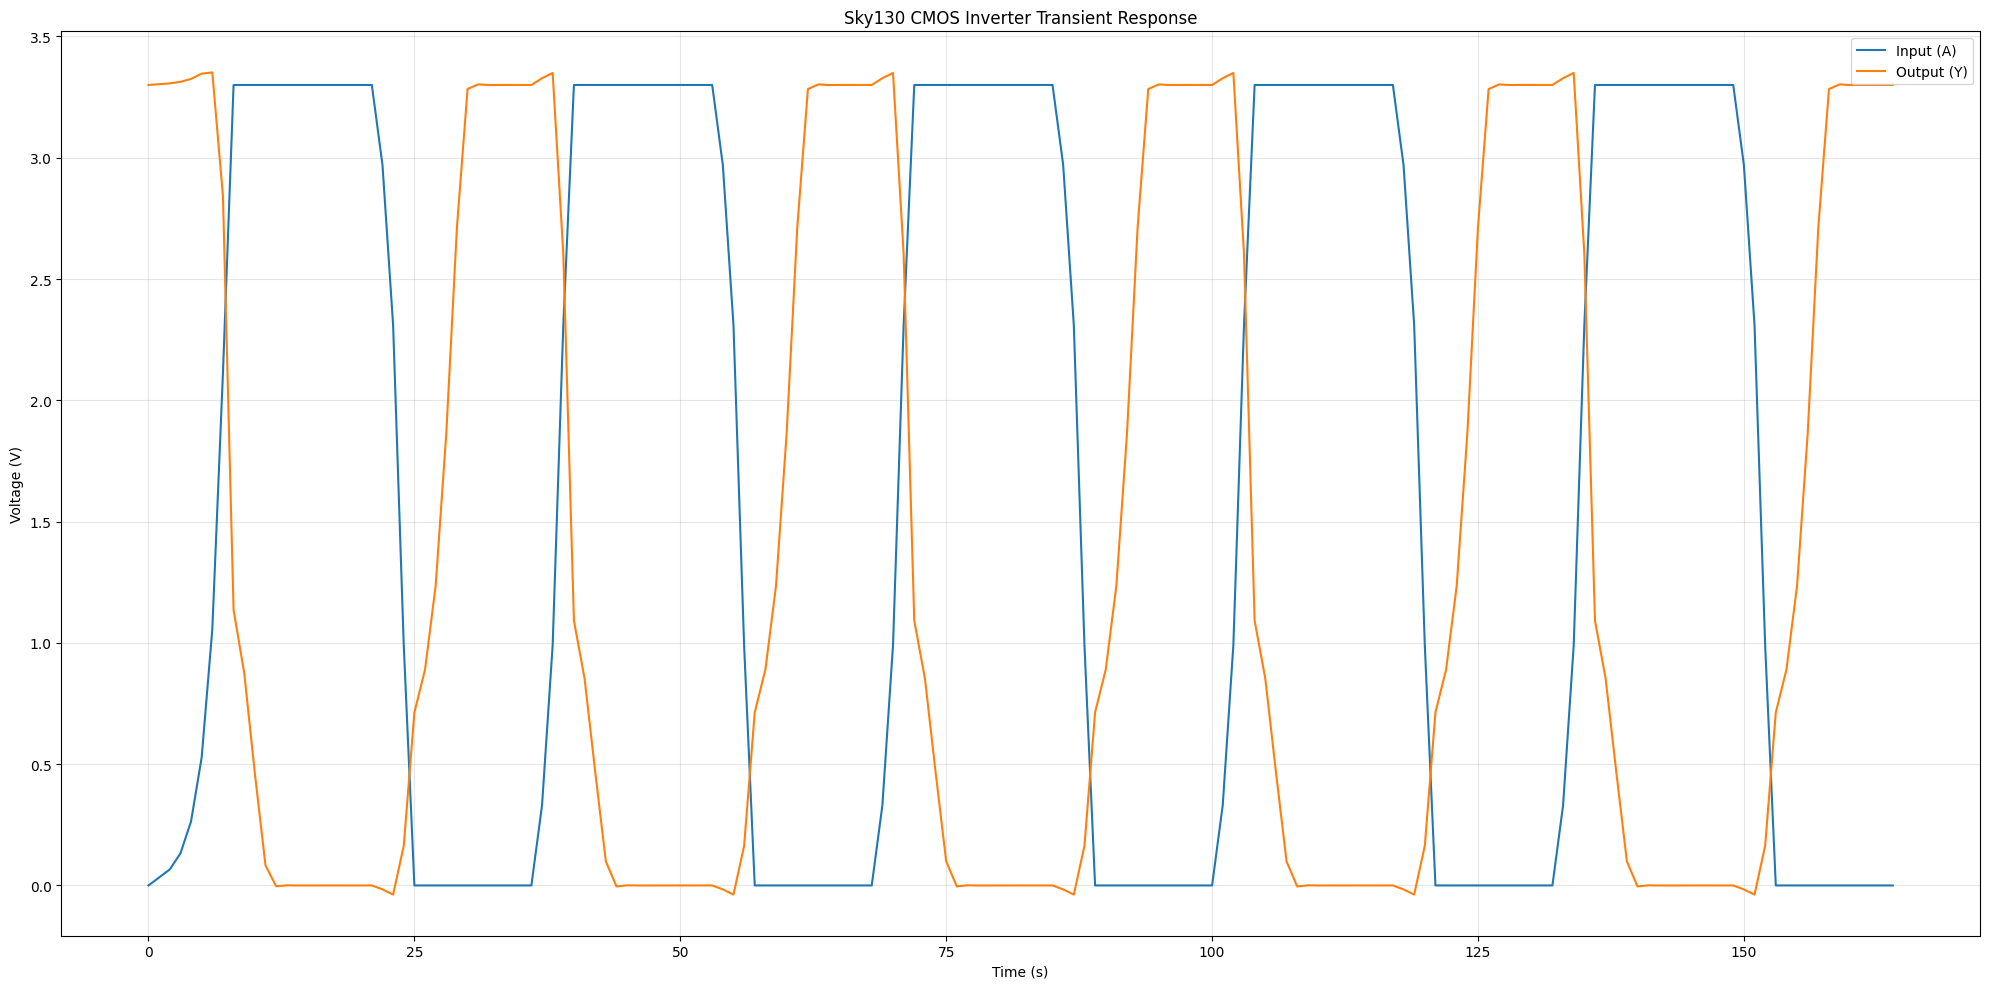

In [11]:
import os
# Import matplotlib fully before PySpice so matplotlib APIs (such as get_data_path)
# are available when PySpice imports/uses matplotlib internally.
import matplotlib.pyplot as plt
%matplotlib inline

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# ============================================================
# Sky130 CMOS Inverter Circuit
# ============================================================
circuit = Circuit('sky130_inv')

# Set scaling option
circuit.raw_spice = '.option scale=0.01u\n'

# Include Sky130 model libraries
pshort_path = "./libs/pshort.lib"
nshort_path = "./libs/nshort.lib"

if not os.path.exists(pshort_path) or not os.path.exists(nshort_path):
    raise FileNotFoundError("❌ Missing required model files in ./libs folder")

circuit.include(pshort_path)
circuit.include(nshort_path)

# Power supplies
circuit.V('dd', 'VPWR', 0, 3.3@u_V)
circuit.V('ss', 'VGND', 0, 0@u_V)

# Input pulse signal
circuit.PulseVoltageSource('in', 'A', 'VGND',
                           initial_value=0@u_V, pulsed_value=3.3@u_V,
                           rise_time=0.1@u_ns, fall_time=0.1@u_ns,
                           pulse_width=2@u_ns, period=4@u_ns, delay_time=0@u_ns)

# MOSFET devices with scaling
circuit.raw_spice += '''
M1000 Y A VPWR VPWR pshort_model.0 w=37 l=23
+  ad=1443 pd=152 as=1517 ps=156
M1001 Y A VGND VGND nshort_model.0 w=35 l=23
+  ad=1435 pd=152 as=1365 ps=148
'''

# Parasitic capacitors
circuit.raw_spice += '''
C0 A Y 0.05fF
C1 VPWR Y 0.11fF
C2 A VPWR 0.07fF
C3 Y 0 4fF
C4 VPWR 0 0.59fF
'''

# Print netlist
print(str(circuit))

# Run simulation
simulator = circuit.simulator()
analysis = simulator.transient(step_time=1@u_ns, end_time=20@u_ns)
print('done')

# Plot results
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Sky130 CMOS Inverter Transient Response')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.plot(analysis.A)
ax.plot(analysis.Y)
ax.legend(('Input (A)', 'Output (Y)'))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

.title sky130_inverter_dc
.lib /home/iraj/VLSI/sky130CircuitDesignWorkshop/design/sky130_fd_pr/models/sky130.lib.spice tt

XM1 out vin vdd vdd sky130_fd_pr__pfet_01v8 w=7 l=0.15
XM2 out vin 0 0 sky130_fd_pr__nfet_01v8 w=0.42 l=0.15
Cload out 0 5e-14
Vdd vdd 0 1.8V
Vin vin 0 1.8V

done


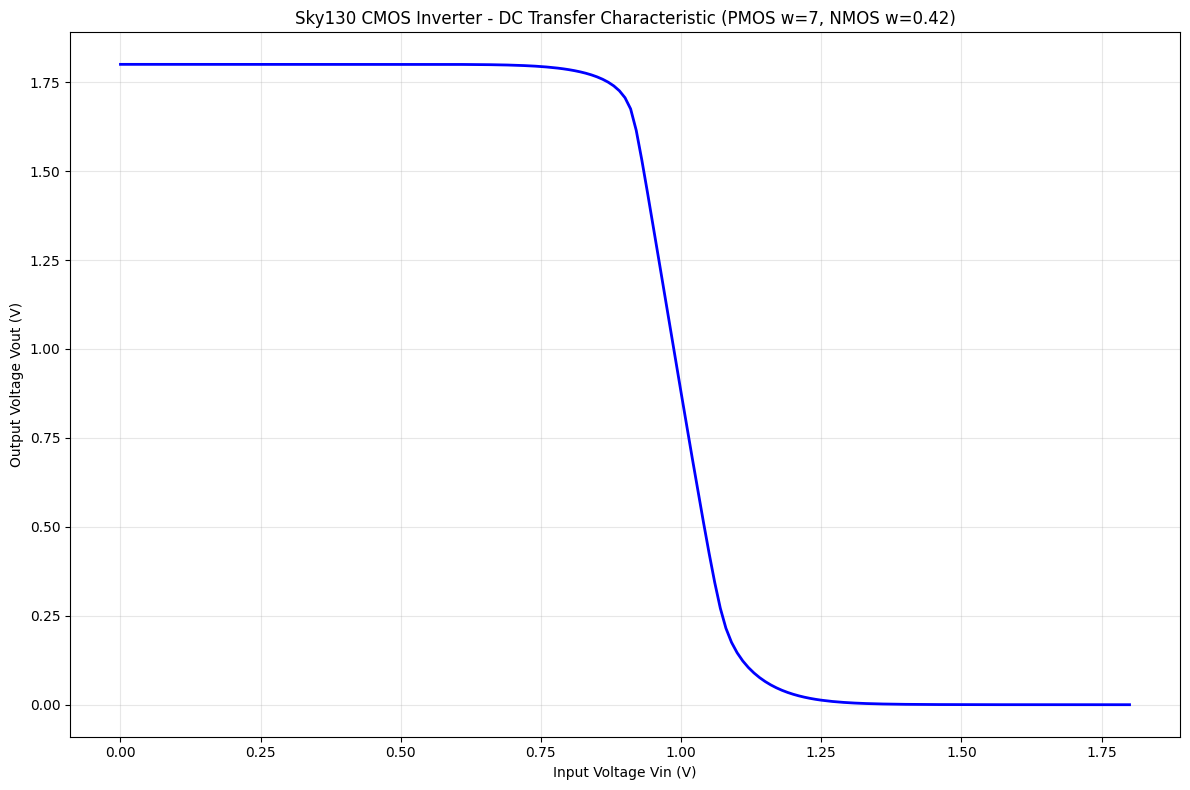

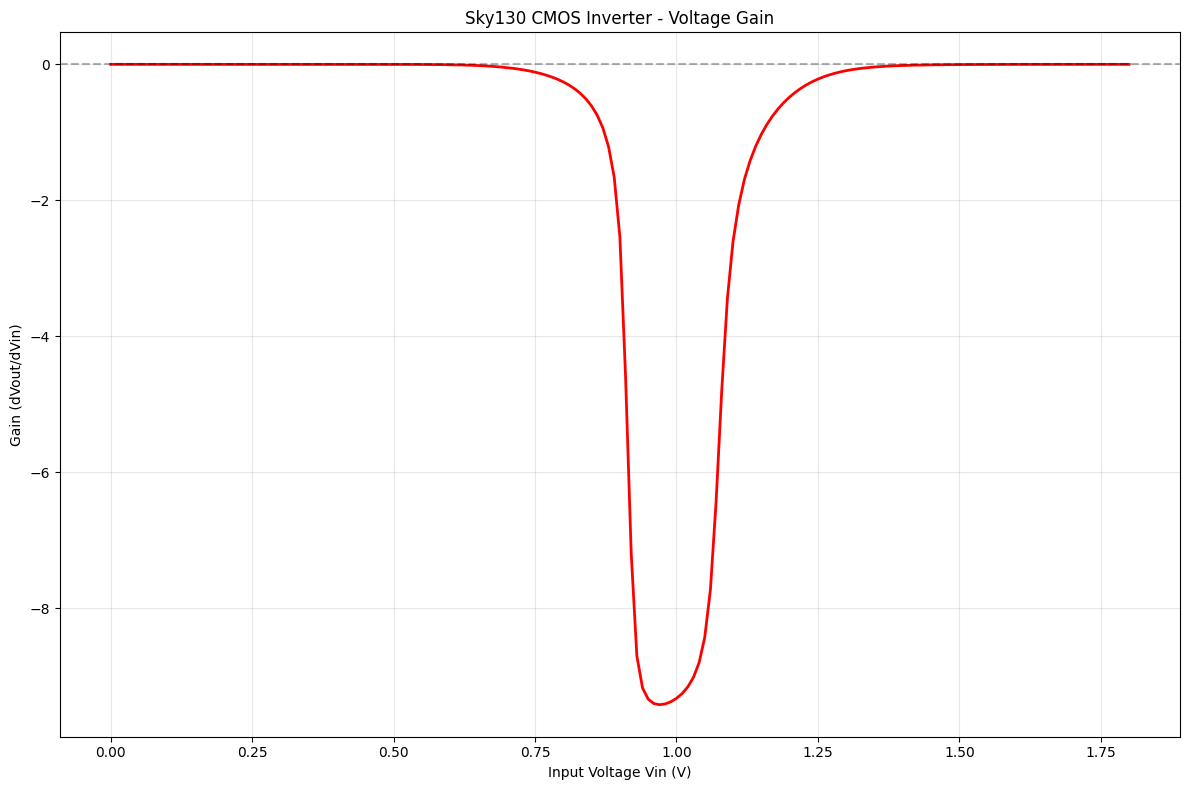

In [19]:
import os
# Import matplotlib fully before PySpice so matplotlib APIs (such as get_data_path)
# are available when PySpice imports/uses matplotlib internally.
import matplotlib.pyplot as plt
%matplotlib inline

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# ============================================================
# Sky130 CMOS Inverter DC Sweep
# ============================================================
circuit = Circuit('sky130_inverter_dc')

# Include Sky130 library files

sky130_lib_path = "/home/iraj/VLSI/sky130CircuitDesignWorkshop/design/sky130_fd_pr/models/sky130.lib.spice"

if not os.path.exists(sky130_lib_path):
    raise FileNotFoundError(f"❌ Missing Sky130 library: {sky130_lib_path}")

circuit.lib(sky130_lib_path, 'tt')

# Netlist Description
circuit.raw_spice += '''
XM1 out vin vdd vdd sky130_fd_pr__pfet_01v8 w=7 l=0.15
XM2 out vin 0 0 sky130_fd_pr__nfet_01v8 w=0.42 l=0.15
'''

# Load capacitor
circuit.C('load', 'out', 0, 50e-15)

# Power supplies
circuit.V('dd', 'vdd', 0, 1.8@u_V)
circuit.V('in', 'vin', 0, 1.8@u_V)

# Print netlist
print(str(circuit))

# Run DC sweep simulation
simulator = circuit.simulator(temperature=27, nominal_temperature=27)
analysis = simulator.dc(Vin=slice(0, 1.8, 0.01))
print('done')

# Plot DC transfer characteristic
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Sky130 CMOS Inverter - DC Transfer Characteristic (PMOS w=7, NMOS w=0.42)')
ax.set_xlabel('Input Voltage Vin (V)')
ax.set_ylabel('Output Voltage Vout (V)')
ax.plot(analysis.Vin, analysis.out, linewidth=2, color='blue')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and plot gain
import numpy as np
fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2.set_title('Sky130 CMOS Inverter - Voltage Gain')
ax2.set_xlabel('Input Voltage Vin (V)')
ax2.set_ylabel('Gain (dVout/dVin)')

vin = analysis.Vin.as_ndarray()
vout = analysis.out.as_ndarray()
gain = np.gradient(vout, vin)

ax2.plot(vin, gain, linewidth=2, color='red')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Simulating VDD = 1.80V...
  VIL=0.880V, VIH=1.150V, VOL=0.065V, VOH=1.739V
  NM_L=0.815V, NM_H=0.589V
Simulating VDD = 1.70V...
  VIL=0.820V, VIH=1.060V, VOL=0.064V, VOH=1.656V
  NM_L=0.756V, NM_H=0.596V
Simulating VDD = 1.60V...
  VIL=0.770V, VIH=0.980V, VOL=0.056V, VOH=1.563V
  NM_L=0.714V, NM_H=0.583V
Simulating VDD = 1.50V...
  VIL=0.720V, VIH=0.910V, VOL=0.044V, VOH=1.471V
  NM_L=0.676V, NM_H=0.561V
Simulating VDD = 1.40V...
  VIL=0.680V, VIH=0.840V, VOL=0.041V, VOH=1.370V
  NM_L=0.639V, NM_H=0.530V
Simulating VDD = 1.30V...
  VIL=0.640V, VIH=0.780V, VOL=0.037V, VOH=1.271V
  NM_L=0.603V, NM_H=0.491V
Simulating VDD = 1.20V...
  VIL=0.600V, VIH=0.730V, VOL=0.030V, VOH=1.175V
  NM_L=0.570V, NM_H=0.445V
Simulating VDD = 1.10V...
  VIL=0.560V, VIH=0.680V, VOL=0.031V, VOH=1.080V
  NM_L=0.529V, NM_H=0.400V
Simulating VDD = 1.00V...
  VIL=0.530V, VIH=0.640V, VOL=0.023V, VOH=0.975V
  NM_L=0.507V, NM_H=0.335V
Simulating VDD = 0.90V...
  VIL=0.490V, VIH=0.600V, VOL=0.019V, VOH=0.882V
  NM_L=

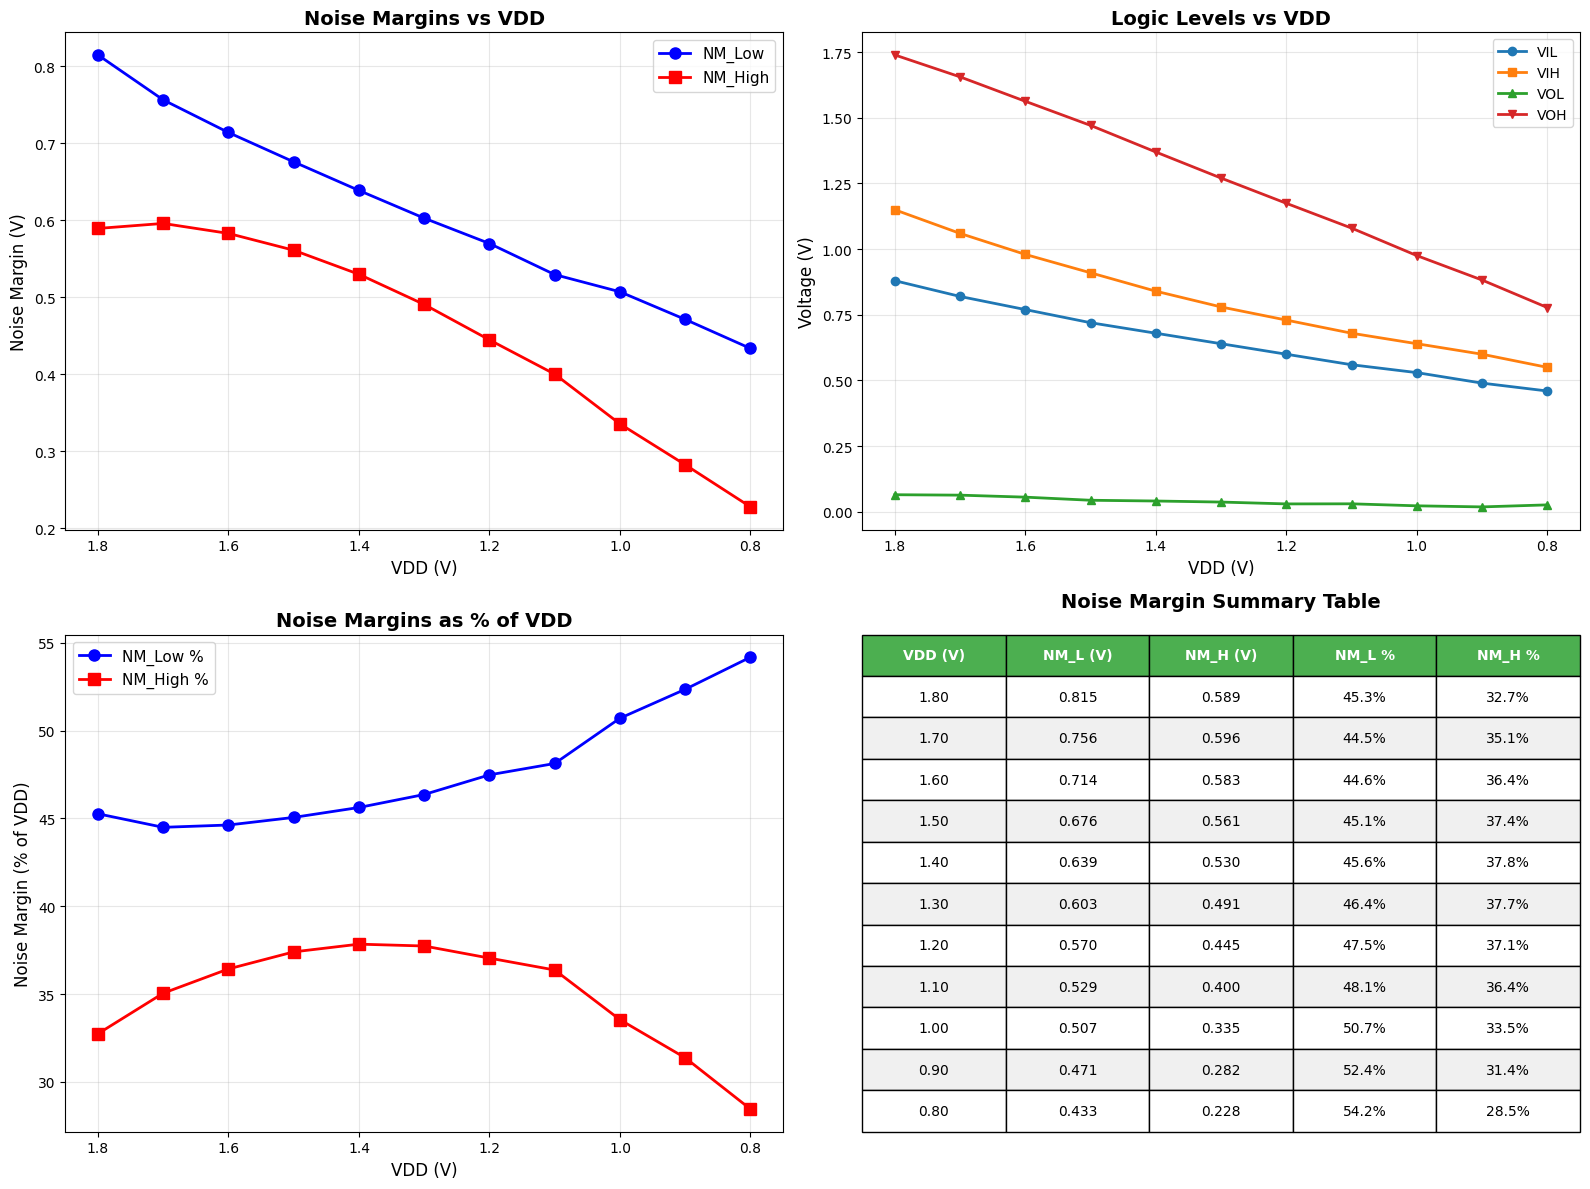


NOISE MARGIN ANALYSIS SUMMARY
VDD = 1.80V | NM_L = 0.815V (45.3%) | NM_H = 0.589V (32.7%)
VDD = 1.70V | NM_L = 0.756V (44.5%) | NM_H = 0.596V (35.1%)
VDD = 1.60V | NM_L = 0.714V (44.6%) | NM_H = 0.583V (36.4%)
VDD = 1.50V | NM_L = 0.676V (45.1%) | NM_H = 0.561V (37.4%)
VDD = 1.40V | NM_L = 0.639V (45.6%) | NM_H = 0.530V (37.8%)
VDD = 1.30V | NM_L = 0.603V (46.4%) | NM_H = 0.491V (37.7%)
VDD = 1.20V | NM_L = 0.570V (47.5%) | NM_H = 0.445V (37.1%)
VDD = 1.10V | NM_L = 0.529V (48.1%) | NM_H = 0.400V (36.4%)
VDD = 1.00V | NM_L = 0.507V (50.7%) | NM_H = 0.335V (33.5%)
VDD = 0.90V | NM_L = 0.471V (52.4%) | NM_H = 0.282V (31.4%)
VDD = 0.80V | NM_L = 0.433V (54.2%) | NM_H = 0.228V (28.5%)


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# ============================================================
# Sky130 CMOS Inverter VDD Sweep with Noise Margin Analysis
# ============================================================

sky130_lib_path = "/home/iraj/VLSI/sky130CircuitDesignWorkshop/design/sky130_fd_pr/models/sky130.lib.spice"

if not os.path.exists(sky130_lib_path):
    raise FileNotFoundError(f"❌ Missing Sky130 library: {sky130_lib_path}")

# VDD sweep range
vdd_values = np.arange(1.8, 0.79, -0.1)  # From 1.8V to 0.8V in 0.1V steps

# Storage for results
results = {
    'vdd': [],
    'vil': [],
    'vih': [],
    'vol': [],
    'voh': [],
    'nm_low': [],
    'nm_high': []
}

# Perform sweep
for vdd in vdd_values:
    print(f"Simulating VDD = {vdd:.2f}V...")
    
    circuit = Circuit('sky130_inverter_dc')
    circuit.lib(sky130_lib_path, 'tt')
    
    circuit.raw_spice += '''
XM1 out vin vdd vdd sky130_fd_pr__pfet_01v8 w=7 l=0.15
XM2 out vin 0 0 sky130_fd_pr__nfet_01v8 w=0.42 l=0.15
'''
    
    circuit.C('load', 'out', 0, 50e-15)
    circuit.V('dd', 'vdd', 0, vdd@u_V)
    circuit.V('in', 'vin', 0, vdd@u_V)
    
    # Run simulation
    simulator = circuit.simulator(temperature=27, nominal_temperature=27)
    analysis = simulator.dc(Vin=slice(0, vdd, 0.01))
    
    # Extract data
    vin = analysis.Vin.as_ndarray()
    vout = analysis.out.as_ndarray()
    gain = np.gradient(vout, vin)
    
    # Find VIL and VIH (where gain = -1)
    gain_neg1_indices = np.where(gain < -0.95)[0]  # Tolerance for gain = -1
    
    if len(gain_neg1_indices) >= 2:
        vil_idx = gain_neg1_indices[0]
        vih_idx = gain_neg1_indices[-1]
        
        vil = vin[vil_idx]
        vih = vin[vih_idx]
        vol = vout[vih_idx]  # Output when input = VIH
        voh = vout[vil_idx]  # Output when input = VIL
        
        # Calculate noise margins
        nm_low = vil - vol
        nm_high = voh - vih
        
        # Store results
        results['vdd'].append(vdd)
        results['vil'].append(vil)
        results['vih'].append(vih)
        results['vol'].append(vol)
        results['voh'].append(voh)
        results['nm_low'].append(nm_low)
        results['nm_high'].append(nm_high)
        
        print(f"  VIL={vil:.3f}V, VIH={vih:.3f}V, VOL={vol:.3f}V, VOH={voh:.3f}V")
        print(f"  NM_L={nm_low:.3f}V, NM_H={nm_high:.3f}V")

print("\n✅ Sweep complete!")

# ============================================================
# Plot Results
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Noise Margins vs VDD
ax1 = axes[0, 0]
ax1.plot(results['vdd'], results['nm_low'], 'o-', linewidth=2, markersize=8, label='NM_Low', color='blue')
ax1.plot(results['vdd'], results['nm_high'], 's-', linewidth=2, markersize=8, label='NM_High', color='red')
ax1.set_xlabel('VDD (V)', fontsize=12)
ax1.set_ylabel('Noise Margin (V)', fontsize=12)
ax1.set_title('Noise Margins vs VDD', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.invert_xaxis()

# Plot 2: VIL, VIH, VOL, VOH vs VDD
ax2 = axes[0, 1]
ax2.plot(results['vdd'], results['vil'], 'o-', linewidth=2, markersize=6, label='VIL')
ax2.plot(results['vdd'], results['vih'], 's-', linewidth=2, markersize=6, label='VIH')
ax2.plot(results['vdd'], results['vol'], '^-', linewidth=2, markersize=6, label='VOL')
ax2.plot(results['vdd'], results['voh'], 'v-', linewidth=2, markersize=6, label='VOH')
ax2.set_xlabel('VDD (V)', fontsize=12)
ax2.set_ylabel('Voltage (V)', fontsize=12)
ax2.set_title('Logic Levels vs VDD', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.invert_xaxis()

# Plot 3: Noise Margin Percentage
ax3 = axes[1, 0]
nm_low_percent = (np.array(results['nm_low']) / np.array(results['vdd'])) * 100
nm_high_percent = (np.array(results['nm_high']) / np.array(results['vdd'])) * 100
ax3.plot(results['vdd'], nm_low_percent, 'o-', linewidth=2, markersize=8, label='NM_Low %', color='blue')
ax3.plot(results['vdd'], nm_high_percent, 's-', linewidth=2, markersize=8, label='NM_High %', color='red')
ax3.set_xlabel('VDD (V)', fontsize=12)
ax3.set_ylabel('Noise Margin (% of VDD)', fontsize=12)
ax3.set_title('Noise Margins as % of VDD', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=11)
ax3.invert_xaxis()

# Plot 4: Summary table
ax4 = axes[1, 1]
ax4.axis('off')
table_data = []
for i in range(len(results['vdd'])):
    table_data.append([
        f"{results['vdd'][i]:.2f}",
        f"{results['nm_low'][i]:.3f}",
        f"{results['nm_high'][i]:.3f}",
        f"{nm_low_percent[i]:.1f}%",
        f"{nm_high_percent[i]:.1f}%"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['VDD (V)', 'NM_L (V)', 'NM_H (V)', 'NM_L %', 'NM_H %'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data) + 1):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax4.set_title('Noise Margin Summary Table', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("NOISE MARGIN ANALYSIS SUMMARY")
print("="*70)
for i in range(len(results['vdd'])):
    print(f"VDD = {results['vdd'][i]:.2f}V | NM_L = {results['nm_low'][i]:.3f}V ({nm_low_percent[i]:.1f}%) | NM_H = {results['nm_high'][i]:.3f}V ({nm_high_percent[i]:.1f}%)")
print("="*70)

NMOS WIDTH SWEEP (PMOS fixed at w=7)

Simulating NMOS w=0.42, PMOS w=7.0...
  VIL=0.880V, VIH=1.150V, VOL=0.065V, VOH=1.739V
  VM=0.990V, Max Gain=-9.42

Simulating NMOS w=0.84, PMOS w=7.0...
  VIL=0.830V, VIH=1.100V, VOL=0.066V, VOH=1.743V
  VM=0.950V, Max Gain=-10.01

Simulating NMOS w=1.26, PMOS w=7.0...
  VIL=0.800V, VIH=1.060V, VOL=0.072V, VOH=1.745V
  VM=0.920V, Max Gain=-10.43

Simulating NMOS w=1.68, PMOS w=7.0...
  VIL=0.770V, VIH=1.030V, VOL=0.073V, VOH=1.749V
  VM=0.900V, Max Gain=-10.79

Simulating NMOS w=2.10, PMOS w=7.0...
  VIL=0.760V, VIH=1.010V, VOL=0.072V, VOH=1.742V
  VM=0.880V, Max Gain=-11.09

PMOS WIDTH SWEEP (NMOS fixed at w=0.42)

Simulating PMOS w=3.50, NMOS w=0.42...
  VIL=0.840V, VIH=1.100V, VOL=0.069V, VOH=1.738V
  VM=0.950V, Max Gain=-10.20

Simulating PMOS w=5.25, NMOS w=0.42...
  VIL=0.860V, VIH=1.120V, VOL=0.065V, VOH=1.743V
  VM=0.970V, Max Gain=-10.23

Simulating PMOS w=7.00, NMOS w=0.42...
  VIL=0.880V, VIH=1.150V, VOL=0.065V, VOH=1.739V
  VM=0.990V, 

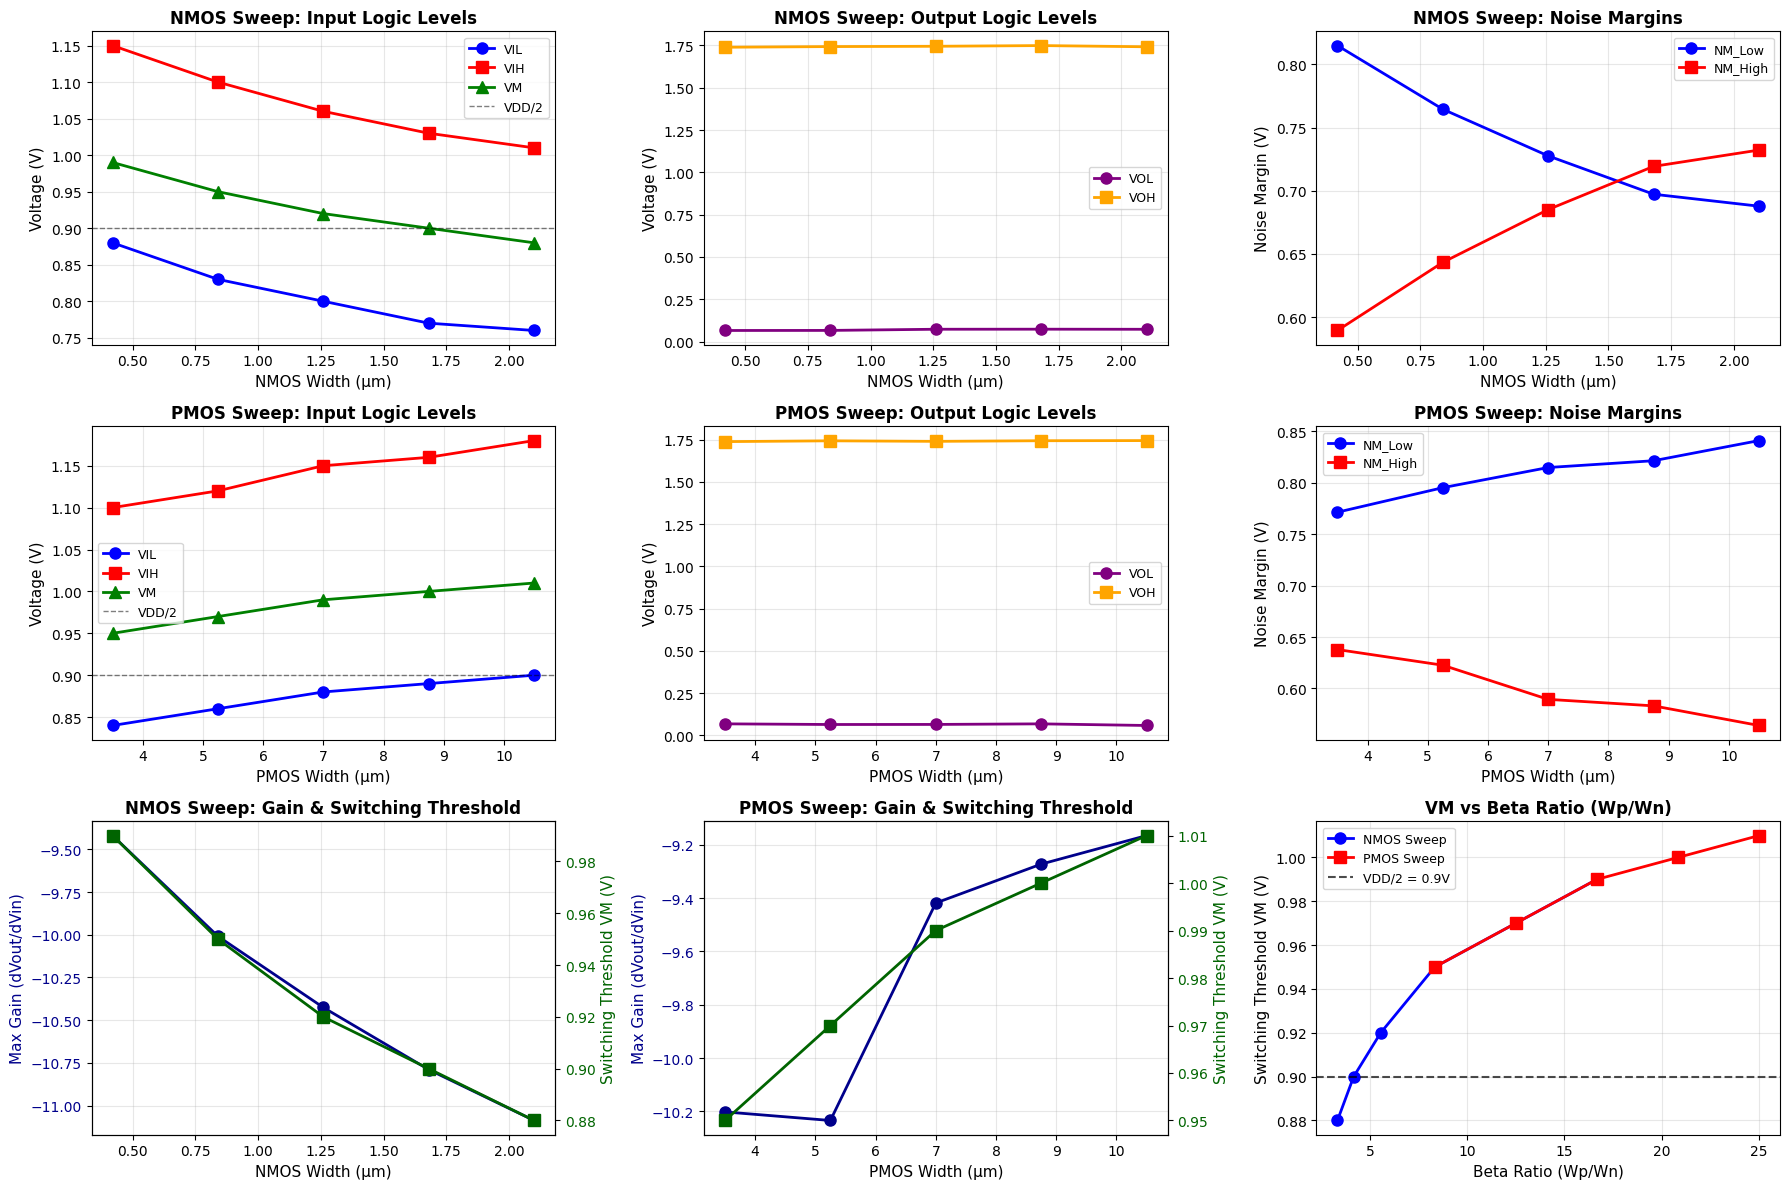


NMOS WIDTH SWEEP SUMMARY (PMOS fixed at w=7)
  NMOS W |   Beta |    VIL |    VIH |    VOL |    VOH |     VM |   NM_L |   NM_H |    Gain
-----------------------------------------------------------------------------------------------
    0.42 |  16.67 |  0.880 |  1.150 |  0.065 |  1.739 |  0.990 |  0.815 |  0.589 |   -9.42
    0.84 |   8.33 |  0.830 |  1.100 |  0.066 |  1.743 |  0.950 |  0.764 |  0.643 |  -10.01
    1.26 |   5.56 |  0.800 |  1.060 |  0.072 |  1.745 |  0.920 |  0.728 |  0.685 |  -10.43
    1.68 |   4.17 |  0.770 |  1.030 |  0.073 |  1.749 |  0.900 |  0.697 |  0.719 |  -10.79
    2.10 |   3.33 |  0.760 |  1.010 |  0.072 |  1.742 |  0.880 |  0.688 |  0.732 |  -11.09

PMOS WIDTH SWEEP SUMMARY (NMOS fixed at w=0.42)
  PMOS W |   Beta |    VIL |    VIH |    VOL |    VOH |     VM |   NM_L |   NM_H |    Gain
-----------------------------------------------------------------------------------------------
    3.50 |   8.33 |  0.840 |  1.100 |  0.069 |  1.738 |  0.950 |  0.771 |  0

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# ============================================================
# Sky130 CMOS Inverter - Device Size Variation Analysis
# ============================================================

sky130_lib_path = "/home/iraj/VLSI/sky130CircuitDesignWorkshop/design/sky130_fd_pr/models/sky130.lib.spice"

if not os.path.exists(sky130_lib_path):
    raise FileNotFoundError(f"❌ Missing Sky130 library: {sky130_lib_path}")

# Fixed parameters
VDD = 1.8
LENGTH = 0.15

# Device size sweep ranges (compliant with Sky130 minimum widths)
# Sky130 minimum width: NMOS >= 0.42μm, PMOS >= 0.42μm
nmos_widths = np.array([0.42, 0.84, 1.26, 1.68, 2.10])  # NMOS sweep
pmos_widths = np.array([3.5, 5.25, 7.0, 8.75, 10.5])     # PMOS sweep

# Storage for results
results = {
    'nmos_sweep': {
        'widths': [],
        'vil': [], 'vih': [], 'vol': [], 'voh': [],
        'vm': [], 'gain_max': []
    },
    'pmos_sweep': {
        'widths': [],
        'vil': [], 'vih': [], 'vol': [], 'voh': [],
        'vm': [], 'gain_max': []
    }
}

def find_logic_levels(vin, vout, gain):
    """Extract VIL, VIH, VOL, VOH, VM from VTC"""
    # Find VIL and VIH (where gain = -1)
    gain_neg1_indices = np.where(gain < -0.95)[0]
    
    if len(gain_neg1_indices) >= 2:
        vil_idx = gain_neg1_indices[0]
        vih_idx = gain_neg1_indices[-1]
        
        vil = vin[vil_idx]
        vih = vin[vih_idx]
        vol = vout[vih_idx]
        voh = vout[vil_idx]
    else:
        vil = vih = vol = voh = np.nan
    
    # Find VM (switching threshold - where Vin = Vout)
    diff = np.abs(vin - vout)
    vm_idx = np.argmin(diff)
    vm = vin[vm_idx]
    
    # Maximum gain
    gain_max = np.min(gain)
    
    return vil, vih, vol, voh, vm, gain_max

# ============================================================
# 1. NMOS Width Sweep (PMOS fixed at w=7)
# ============================================================
print("="*70)
print("NMOS WIDTH SWEEP (PMOS fixed at w=7)")
print("="*70)

pmos_fixed = 7.0

for nmos_w in nmos_widths:
    print(f"\nSimulating NMOS w={nmos_w:.2f}, PMOS w={pmos_fixed}...")
    
    circuit = Circuit('inverter_nmos_sweep')
    circuit.lib(sky130_lib_path, 'tt')
    
    circuit.raw_spice += f'''
XM1 out vin vdd vdd sky130_fd_pr__pfet_01v8 w={pmos_fixed} l={LENGTH}
XM2 out vin 0 0 sky130_fd_pr__nfet_01v8 w={nmos_w} l={LENGTH}
'''
    
    circuit.C('load', 'out', 0, 50e-15)
    circuit.V('dd', 'vdd', 0, VDD@u_V)
    circuit.V('in', 'vin', 0, VDD@u_V)
    
    simulator = circuit.simulator(temperature=27, nominal_temperature=27)
    analysis = simulator.dc(Vin=slice(0, VDD, 0.01))
    
    vin = analysis.Vin.as_ndarray()
    vout = analysis.out.as_ndarray()
    gain = np.gradient(vout, vin)
    
    vil, vih, vol, voh, vm, gain_max = find_logic_levels(vin, vout, gain)
    
    results['nmos_sweep']['widths'].append(nmos_w)
    results['nmos_sweep']['vil'].append(vil)
    results['nmos_sweep']['vih'].append(vih)
    results['nmos_sweep']['vol'].append(vol)
    results['nmos_sweep']['voh'].append(voh)
    results['nmos_sweep']['vm'].append(vm)
    results['nmos_sweep']['gain_max'].append(gain_max)
    
    print(f"  VIL={vil:.3f}V, VIH={vih:.3f}V, VOL={vol:.3f}V, VOH={voh:.3f}V")
    print(f"  VM={vm:.3f}V, Max Gain={gain_max:.2f}")

# ============================================================
# 2. PMOS Width Sweep (NMOS fixed at w=0.42)
# ============================================================
print("\n" + "="*70)
print("PMOS WIDTH SWEEP (NMOS fixed at w=0.42)")
print("="*70)

nmos_fixed = 0.42

for pmos_w in pmos_widths:
    print(f"\nSimulating PMOS w={pmos_w:.2f}, NMOS w={nmos_fixed}...")
    
    circuit = Circuit('inverter_pmos_sweep')
    circuit.lib(sky130_lib_path, 'tt')
    
    circuit.raw_spice += f'''
XM1 out vin vdd vdd sky130_fd_pr__pfet_01v8 w={pmos_w} l={LENGTH}
XM2 out vin 0 0 sky130_fd_pr__nfet_01v8 w={nmos_fixed} l={LENGTH}
'''
    
    circuit.C('load', 'out', 0, 50e-15)
    circuit.V('dd', 'vdd', 0, VDD@u_V)
    circuit.V('in', 'vin', 0, VDD@u_V)
    
    simulator = circuit.simulator(temperature=27, nominal_temperature=27)
    analysis = simulator.dc(Vin=slice(0, VDD, 0.01))
    
    vin = analysis.Vin.as_ndarray()
    vout = analysis.out.as_ndarray()
    gain = np.gradient(vout, vin)
    
    vil, vih, vol, voh, vm, gain_max = find_logic_levels(vin, vout, gain)
    
    results['pmos_sweep']['widths'].append(pmos_w)
    results['pmos_sweep']['vil'].append(vil)
    results['pmos_sweep']['vih'].append(vih)
    results['pmos_sweep']['vol'].append(vol)
    results['pmos_sweep']['voh'].append(voh)
    results['pmos_sweep']['vm'].append(vm)
    results['pmos_sweep']['gain_max'].append(gain_max)
    
    print(f"  VIL={vil:.3f}V, VIH={vih:.3f}V, VOL={vol:.3f}V, VOH={voh:.3f}V")
    print(f"  VM={vm:.3f}V, Max Gain={gain_max:.2f}")

print("\n✅ Device size sweep complete!")

# ============================================================
# Plot Results
# ============================================================

fig = plt.figure(figsize=(18, 12))

# ============================================================
# NMOS Sweep Plots
# ============================================================

# Plot 1: NMOS - Logic Levels
ax1 = plt.subplot(3, 3, 1)
ax1.plot(results['nmos_sweep']['widths'], results['nmos_sweep']['vil'], 'o-', 
         linewidth=2, markersize=8, label='VIL', color='blue')
ax1.plot(results['nmos_sweep']['widths'], results['nmos_sweep']['vih'], 's-', 
         linewidth=2, markersize=8, label='VIH', color='red')
ax1.plot(results['nmos_sweep']['widths'], results['nmos_sweep']['vm'], '^-', 
         linewidth=2, markersize=8, label='VM', color='green')
ax1.axhline(y=VDD/2, color='black', linestyle='--', linewidth=1, alpha=0.5, label='VDD/2')
ax1.set_xlabel('NMOS Width (μm)', fontsize=11)
ax1.set_ylabel('Voltage (V)', fontsize=11)
ax1.set_title('NMOS Sweep: Input Logic Levels', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9)

# Plot 2: NMOS - Output Levels
ax2 = plt.subplot(3, 3, 2)
ax2.plot(results['nmos_sweep']['widths'], results['nmos_sweep']['vol'], 'o-', 
         linewidth=2, markersize=8, label='VOL', color='purple')
ax2.plot(results['nmos_sweep']['widths'], results['nmos_sweep']['voh'], 's-', 
         linewidth=2, markersize=8, label='VOH', color='orange')
ax2.set_xlabel('NMOS Width (μm)', fontsize=11)
ax2.set_ylabel('Voltage (V)', fontsize=11)
ax2.set_title('NMOS Sweep: Output Logic Levels', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9)

# Plot 3: NMOS - Noise Margins
ax3 = plt.subplot(3, 3, 3)
nm_low_nmos = np.array(results['nmos_sweep']['vil']) - np.array(results['nmos_sweep']['vol'])
nm_high_nmos = np.array(results['nmos_sweep']['voh']) - np.array(results['nmos_sweep']['vih'])
ax3.plot(results['nmos_sweep']['widths'], nm_low_nmos, 'o-', 
         linewidth=2, markersize=8, label='NM_Low', color='blue')
ax3.plot(results['nmos_sweep']['widths'], nm_high_nmos, 's-', 
         linewidth=2, markersize=8, label='NM_High', color='red')
ax3.set_xlabel('NMOS Width (μm)', fontsize=11)
ax3.set_ylabel('Noise Margin (V)', fontsize=11)
ax3.set_title('NMOS Sweep: Noise Margins', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=9)

# ============================================================
# PMOS Sweep Plots
# ============================================================

# Plot 4: PMOS - Logic Levels
ax4 = plt.subplot(3, 3, 4)
ax4.plot(results['pmos_sweep']['widths'], results['pmos_sweep']['vil'], 'o-', 
         linewidth=2, markersize=8, label='VIL', color='blue')
ax4.plot(results['pmos_sweep']['widths'], results['pmos_sweep']['vih'], 's-', 
         linewidth=2, markersize=8, label='VIH', color='red')
ax4.plot(results['pmos_sweep']['widths'], results['pmos_sweep']['vm'], '^-', 
         linewidth=2, markersize=8, label='VM', color='green')
ax4.axhline(y=VDD/2, color='black', linestyle='--', linewidth=1, alpha=0.5, label='VDD/2')
ax4.set_xlabel('PMOS Width (μm)', fontsize=11)
ax4.set_ylabel('Voltage (V)', fontsize=11)
ax4.set_title('PMOS Sweep: Input Logic Levels', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=9)

# Plot 5: PMOS - Output Levels
ax5 = plt.subplot(3, 3, 5)
ax5.plot(results['pmos_sweep']['widths'], results['pmos_sweep']['vol'], 'o-', 
         linewidth=2, markersize=8, label='VOL', color='purple')
ax5.plot(results['pmos_sweep']['widths'], results['pmos_sweep']['voh'], 's-', 
         linewidth=2, markersize=8, label='VOH', color='orange')
ax5.set_xlabel('PMOS Width (μm)', fontsize=11)
ax5.set_ylabel('Voltage (V)', fontsize=11)
ax5.set_title('PMOS Sweep: Output Logic Levels', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=9)

# Plot 6: PMOS - Noise Margins
ax6 = plt.subplot(3, 3, 6)
nm_low_pmos = np.array(results['pmos_sweep']['vil']) - np.array(results['pmos_sweep']['vol'])
nm_high_pmos = np.array(results['pmos_sweep']['voh']) - np.array(results['pmos_sweep']['vih'])
ax6.plot(results['pmos_sweep']['widths'], nm_low_pmos, 'o-', 
         linewidth=2, markersize=8, label='NM_Low', color='blue')
ax6.plot(results['pmos_sweep']['widths'], nm_high_pmos, 's-', 
         linewidth=2, markersize=8, label='NM_High', color='red')
ax6.set_xlabel('PMOS Width (μm)', fontsize=11)
ax6.set_ylabel('Noise Margin (V)', fontsize=11)
ax6.set_title('PMOS Sweep: Noise Margins', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)
ax6.legend(fontsize=9)

# ============================================================
# Gain and Switching Threshold Plots
# ============================================================

# Plot 7: NMOS - Gain and VM
ax7 = plt.subplot(3, 3, 7)
ax7_twin = ax7.twinx()
line1 = ax7.plot(results['nmos_sweep']['widths'], results['nmos_sweep']['gain_max'], 'o-', 
                 linewidth=2, markersize=8, label='Max Gain', color='darkblue')
line2 = ax7_twin.plot(results['nmos_sweep']['widths'], results['nmos_sweep']['vm'], 's-', 
                      linewidth=2, markersize=8, label='VM', color='darkgreen')
ax7.set_xlabel('NMOS Width (μm)', fontsize=11)
ax7.set_ylabel('Max Gain (dVout/dVin)', fontsize=11, color='darkblue')
ax7_twin.set_ylabel('Switching Threshold VM (V)', fontsize=11, color='darkgreen')
ax7.set_title('NMOS Sweep: Gain & Switching Threshold', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='y', labelcolor='darkblue')
ax7_twin.tick_params(axis='y', labelcolor='darkgreen')

# Plot 8: PMOS - Gain and VM
ax8 = plt.subplot(3, 3, 8)
ax8_twin = ax8.twinx()
line3 = ax8.plot(results['pmos_sweep']['widths'], results['pmos_sweep']['gain_max'], 'o-', 
                 linewidth=2, markersize=8, label='Max Gain', color='darkblue')
line4 = ax8_twin.plot(results['pmos_sweep']['widths'], results['pmos_sweep']['vm'], 's-', 
                      linewidth=2, markersize=8, label='VM', color='darkgreen')
ax8.set_xlabel('PMOS Width (μm)', fontsize=11)
ax8.set_ylabel('Max Gain (dVout/dVin)', fontsize=11, color='darkblue')
ax8_twin.set_ylabel('Switching Threshold VM (V)', fontsize=11, color='darkgreen')
ax8.set_title('PMOS Sweep: Gain & Switching Threshold', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3)
ax8.tick_params(axis='y', labelcolor='darkblue')
ax8_twin.tick_params(axis='y', labelcolor='darkgreen')

# Plot 9: Beta Ratio Analysis
ax9 = plt.subplot(3, 3, 9)
# Calculate beta ratios
beta_ratio_nmos = pmos_fixed / np.array(results['nmos_sweep']['widths'])
beta_ratio_pmos = np.array(results['pmos_sweep']['widths']) / nmos_fixed

ax9.plot(beta_ratio_nmos, results['nmos_sweep']['vm'], 'o-', 
         linewidth=2, markersize=8, label='NMOS Sweep', color='blue')
ax9.plot(beta_ratio_pmos, results['pmos_sweep']['vm'], 's-', 
         linewidth=2, markersize=8, label='PMOS Sweep', color='red')
ax9.axhline(y=VDD/2, color='black', linestyle='--', linewidth=1.5, 
            label=f'VDD/2 = {VDD/2}V', alpha=0.7)
ax9.set_xlabel('Beta Ratio (Wp/Wn)', fontsize=11)
ax9.set_ylabel('Switching Threshold VM (V)', fontsize=11)
ax9.set_title('VM vs Beta Ratio (Wp/Wn)', fontsize=12, fontweight='bold')
ax9.grid(True, alpha=0.3)
ax9.legend(fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================
# Print Summary Tables
# ============================================================

print("\n" + "="*95)
print("NMOS WIDTH SWEEP SUMMARY (PMOS fixed at w=7)")
print("="*95)
print(f"{'NMOS W':>8} | {'Beta':>6} | {'VIL':>6} | {'VIH':>6} | {'VOL':>6} | {'VOH':>6} | {'VM':>6} | {'NM_L':>6} | {'NM_H':>6} | {'Gain':>7}")
print("-"*95)
for i in range(len(results['nmos_sweep']['widths'])):
    beta = pmos_fixed / results['nmos_sweep']['widths'][i]
    print(f"{results['nmos_sweep']['widths'][i]:>8.2f} | "
          f"{beta:>6.2f} | "
          f"{results['nmos_sweep']['vil'][i]:>6.3f} | "
          f"{results['nmos_sweep']['vih'][i]:>6.3f} | "
          f"{results['nmos_sweep']['vol'][i]:>6.3f} | "
          f"{results['nmos_sweep']['voh'][i]:>6.3f} | "
          f"{results['nmos_sweep']['vm'][i]:>6.3f} | "
          f"{nm_low_nmos[i]:>6.3f} | "
          f"{nm_high_nmos[i]:>6.3f} | "
          f"{results['nmos_sweep']['gain_max'][i]:>7.2f}")

print("\n" + "="*95)
print("PMOS WIDTH SWEEP SUMMARY (NMOS fixed at w=0.42)")
print("="*95)
print(f"{'PMOS W':>8} | {'Beta':>6} | {'VIL':>6} | {'VIH':>6} | {'VOL':>6} | {'VOH':>6} | {'VM':>6} | {'NM_L':>6} | {'NM_H':>6} | {'Gain':>7}")
print("-"*95)
for i in range(len(results['pmos_sweep']['widths'])):
    beta = results['pmos_sweep']['widths'][i] / nmos_fixed
    print(f"{results['pmos_sweep']['widths'][i]:>8.2f} | "
          f"{beta:>6.2f} | "
          f"{results['pmos_sweep']['vil'][i]:>6.3f} | "
          f"{results['pmos_sweep']['vih'][i]:>6.3f} | "
          f"{results['pmos_sweep']['vol'][i]:>6.3f} | "
          f"{results['pmos_sweep']['voh'][i]:>6.3f} | "
          f"{results['pmos_sweep']['vm'][i]:>6.3f} | "
          f"{nm_low_pmos[i]:>6.3f} | "
          f"{nm_high_pmos[i]:>6.3f} | "
          f"{results['pmos_sweep']['gain_max'][i]:>7.2f}")
print("="*95)

.title sky130_inverter_dc
.lib /home/iraj/VLSI/sky130CircuitDesignWorkshop/design/sky130_fd_pr/models/sky130.lib.spice tt

XM1 out vin vdd vdd sky130_fd_pr__pfet_01v8 w=7 l=0.15
XM2 out vin 0 0 sky130_fd_pr__nfet_01v8 w=0.42 l=0.15
Cload out 0 5e-14
Vdd vdd 0 1.8V
Vin vin 0 1.8V

✅ Simulation done

           DC ANALYSIS PARAMETERS
VDD                    : 1.800 V
Switching Threshold Vm : 0.988 V
Maximum Gain           : -9.423
------------------------------------------------------------
VIL (Input Low)        : 0.874 V
VIH (Input High)       : 1.800 V
VOL (Output Low)       : 0.000 V
VOH (Output High)      : 1.800 V
------------------------------------------------------------
NML (Noise Margin Low) : 0.874 V
NMH (Noise Margin High): -0.000 V
Average Noise Margin   : 0.437 V


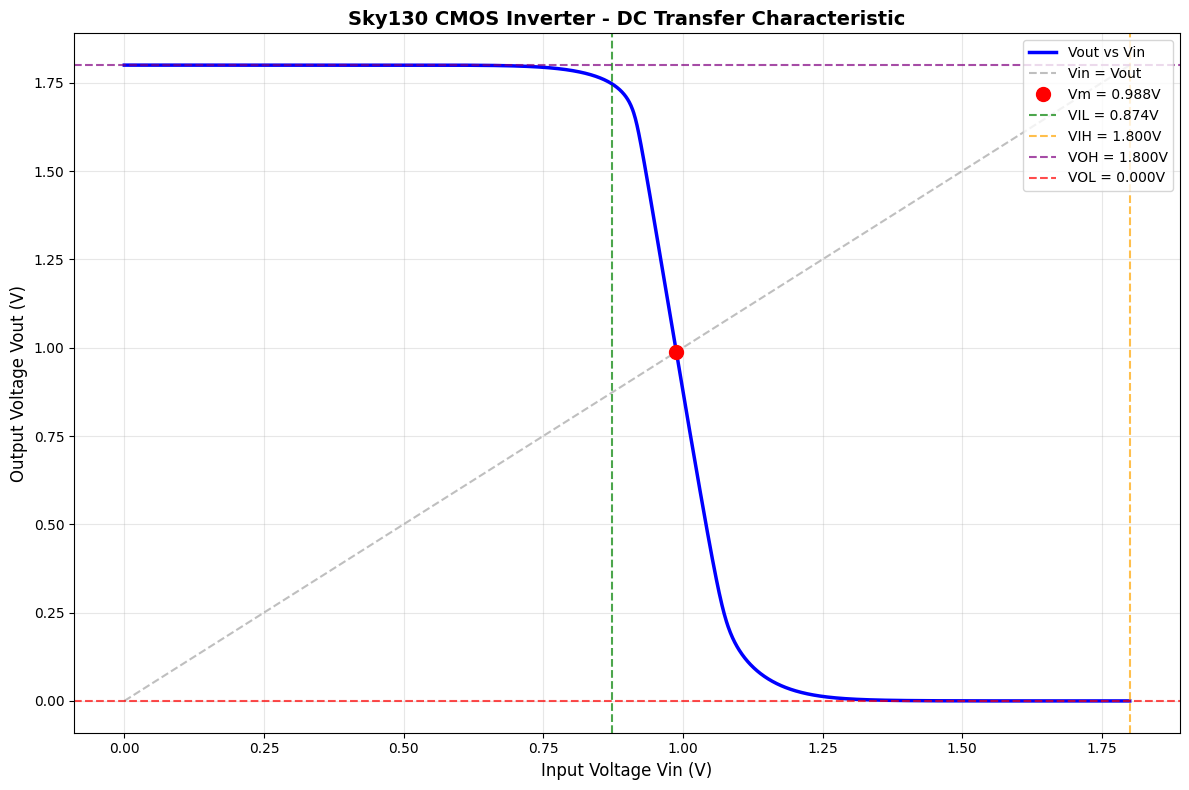

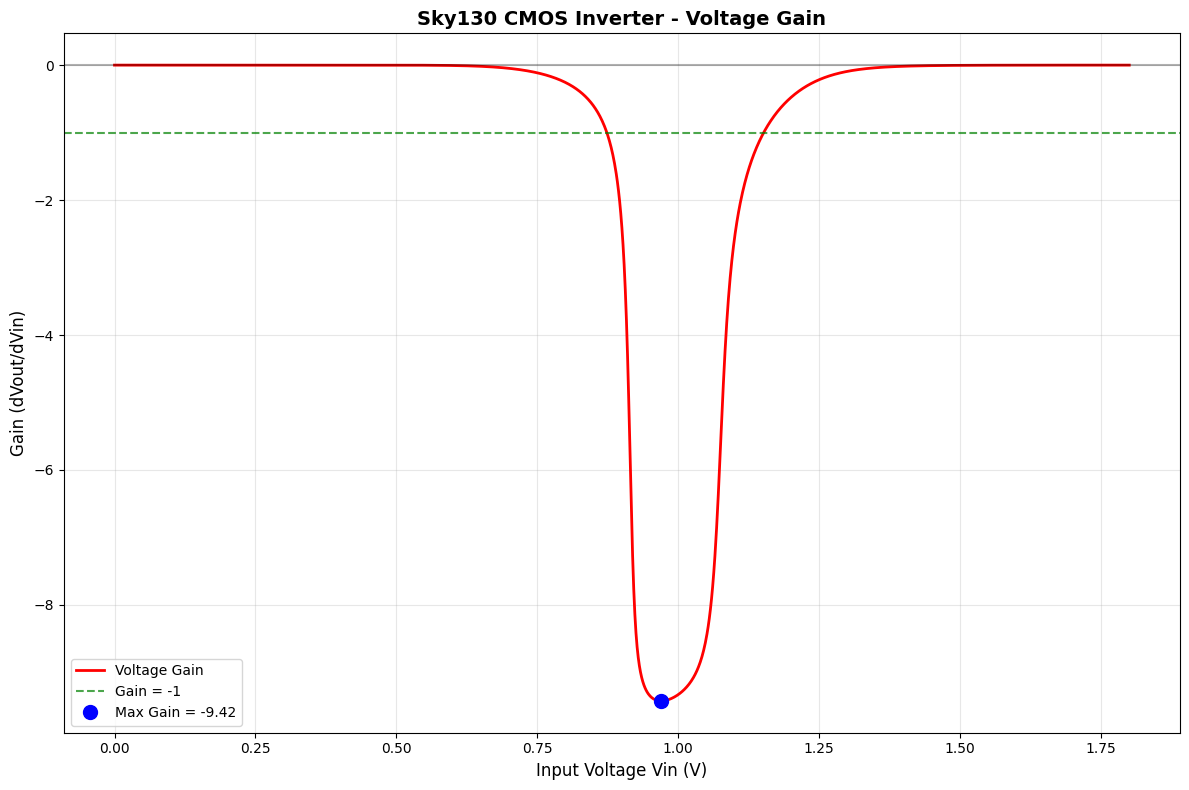

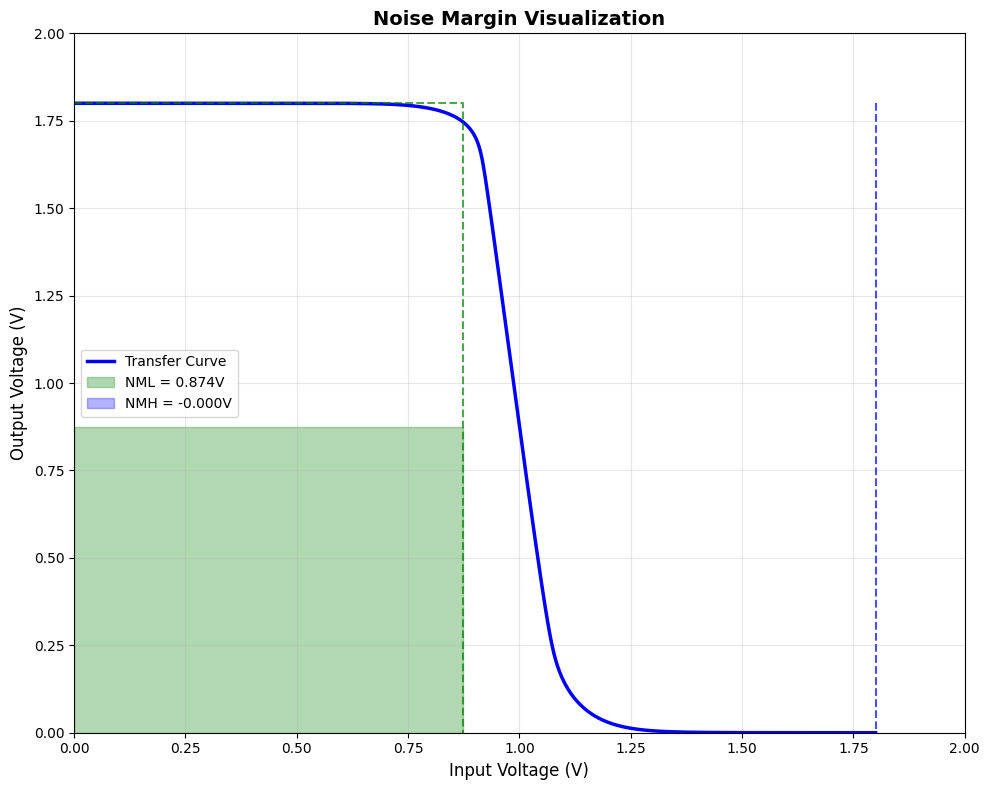

In [20]:
import os
import numpy as np
# Import matplotlib fully before PySpice so matplotlib APIs (such as get_data_path)
# are available when PySpice imports/uses matplotlib internally.
import matplotlib.pyplot as plt
%matplotlib inline

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# ============================================================
# Sky130 CMOS Inverter DC Analysis with Parameters
# ============================================================
circuit = Circuit('sky130_inverter_dc')

# Include Sky130 library files
sky130_lib_path = "/home/iraj/VLSI/sky130CircuitDesignWorkshop/design/sky130_fd_pr/models/sky130.lib.spice"

if not os.path.exists(sky130_lib_path):
    raise FileNotFoundError(f"❌ Missing Sky130 library: {sky130_lib_path}")

circuit.lib(sky130_lib_path, 'tt')

# Netlist Description
circuit.raw_spice += '''
XM1 out vin vdd vdd sky130_fd_pr__pfet_01v8 w=7 l=0.15
XM2 out vin 0 0 sky130_fd_pr__nfet_01v8 w=0.42 l=0.15
'''

# Load capacitor
circuit.C('load', 'out', 0, 50e-15)

# Power supplies
circuit.V('dd', 'vdd', 0, 1.8@u_V)
circuit.V('in', 'vin', 0, 1.8@u_V)

# Print netlist
print(str(circuit))

# Run DC sweep simulation
simulator = circuit.simulator(temperature=27, nominal_temperature=27)
analysis = simulator.dc(Vin=slice(0, 1.8, 0.001))
print('✅ Simulation done\n')

# Extract data
vin = analysis.Vin.as_ndarray()
vout = analysis.out.as_ndarray()
vdd_val = 1.8

# Calculate gain (derivative)
gain = np.gradient(vout, vin)

# ============================================================
# Calculate DC Parameters
# ============================================================

# Find switching threshold (Vm) - where Vin = Vout
idx_vm = np.argmin(np.abs(vin - vout))
Vm = vin[idx_vm]

# Find maximum gain point
idx_max_gain = np.argmin(gain)  # Most negative gain
max_gain = gain[idx_max_gain]

# Find VIL (input low voltage) - where gain = -1
# VIL is where the gain crosses -1 on the left side of Vm
try:
    idx_vil = np.where((vin < Vm) & (gain < -1))[0][0]
    VIL = vin[idx_vil]
    VOL = vout[idx_vil]
except:
    VIL = None
    VOL = None

# Find VIH (input high voltage) - where gain = -1
# VIH is where the gain crosses -1 on the right side of Vm
try:
    idx_vih = np.where((vin > Vm) & (gain > -1))[0][-1]
    VIH = vin[idx_vih]
    VOH = vout[idx_vih]
except:
    VIH = None
    VOH = None

# VOH (output high) - output when input is 0
VOH_actual = vout[0]

# VOL (output low) - output when input is VDD
VOL_actual = vout[-1]

# Calculate Noise Margins
if VIL is not None and VIH is not None:
    NML = VIL - VOL_actual  # Noise Margin Low
    NMH = VOH_actual - VIH  # Noise Margin High
else:
    NML = None
    NMH = None

# ============================================================
# Print Results
# ============================================================
print("="*60)
print("           DC ANALYSIS PARAMETERS")
print("="*60)
print(f"VDD                    : {vdd_val:.3f} V")
print(f"Switching Threshold Vm : {Vm:.3f} V")
print(f"Maximum Gain           : {max_gain:.3f}")
print("-"*60)
if VIL is not None:
    print(f"VIL (Input Low)        : {VIL:.3f} V")
if VIH is not None:
    print(f"VIH (Input High)       : {VIH:.3f} V")
print(f"VOL (Output Low)       : {VOL_actual:.3f} V")
print(f"VOH (Output High)      : {VOH_actual:.3f} V")
print("-"*60)
if NML is not None and NMH is not None:
    print(f"NML (Noise Margin Low) : {NML:.3f} V")
    print(f"NMH (Noise Margin High): {NMH:.3f} V")
    print(f"Average Noise Margin   : {(NML + NMH)/2:.3f} V")
print("="*60)

# ============================================================
# Plot 1: DC Transfer Characteristic with Parameters
# ============================================================
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Sky130 CMOS Inverter - DC Transfer Characteristic', fontsize=14, fontweight='bold')
ax.set_xlabel('Input Voltage Vin (V)', fontsize=12)
ax.set_ylabel('Output Voltage Vout (V)', fontsize=12)

# Main curve
ax.plot(vin, vout, linewidth=2.5, color='blue', label='Vout vs Vin')

# Unity gain line
ax.plot(vin, vin, '--', color='gray', alpha=0.5, label='Vin = Vout')

# Mark key points
ax.plot(Vm, Vm, 'ro', markersize=10, label=f'Vm = {Vm:.3f}V')
if VIL is not None:
    ax.axvline(VIL, color='green', linestyle='--', alpha=0.7, label=f'VIL = {VIL:.3f}V')
if VIH is not None:
    ax.axvline(VIH, color='orange', linestyle='--', alpha=0.7, label=f'VIH = {VIH:.3f}V')
ax.axhline(VOH_actual, color='purple', linestyle='--', alpha=0.7, label=f'VOH = {VOH_actual:.3f}V')
ax.axhline(VOL_actual, color='red', linestyle='--', alpha=0.7, label=f'VOL = {VOL_actual:.3f}V')

ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2: Voltage Gain
# ============================================================
fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2.set_title('Sky130 CMOS Inverter - Voltage Gain', fontsize=14, fontweight='bold')
ax2.set_xlabel('Input Voltage Vin (V)', fontsize=12)
ax2.set_ylabel('Gain (dVout/dVin)', fontsize=12)

ax2.plot(vin, gain, linewidth=2, color='red', label='Voltage Gain')
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.axhline(y=-1, color='green', linestyle='--', alpha=0.7, label='Gain = -1')
ax2.plot(vin[idx_max_gain], max_gain, 'bo', markersize=10, label=f'Max Gain = {max_gain:.2f}')

ax2.grid(True, alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Plot 3: Noise Margin Visualization
# ============================================================
if VIL is not None and VIH is not None:
    fig3, ax3 = plt.subplots(figsize=(10, 8))
    ax3.set_title('Noise Margin Visualization', fontsize=14, fontweight='bold')
    ax3.set_xlim(0, 2)
    ax3.set_ylim(0, 2)
    ax3.set_xlabel('Input Voltage (V)', fontsize=12)
    ax3.set_ylabel('Output Voltage (V)', fontsize=12)
    
    # Draw transfer characteristic
    ax3.plot(vin, vout, 'b-', linewidth=2.5, label='Transfer Curve')
    
    # Draw noise margin rectangles
    # NML region
    rect_nml = plt.Rectangle((0, VOL_actual), VIL, NML, 
                              alpha=0.3, color='green', label=f'NML = {NML:.3f}V')
    ax3.add_patch(rect_nml)
    
    # NMH region
    rect_nmh = plt.Rectangle((VIH, VIH), vdd_val-VIH, NMH, 
                              alpha=0.3, color='blue', label=f'NMH = {NMH:.3f}V')
    ax3.add_patch(rect_nmh)
    
    # Mark critical points
    ax3.plot([0, VIL, VIL], [VOH_actual, VOH_actual, VOL_actual], 'g--', alpha=0.7)
    ax3.plot([VIH, VIH, vdd_val], [VOH_actual, VIH, VOL_actual], 'b--', alpha=0.7)
    
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    plt.tight_layout()
    plt.show()